# Phase 3: Investment Fund
* Student Name: Evan Callaghan
* Student Pace: Part Time
* Scheduled Project Review Date/Time: 
* Instructor Name: Mark Barbour

## Introduction
*Callaghan Investments* is a newly formed investment firm specializing in asset allocation and portfolio management. As part of our goal of onboarding the influx of retail investors entering the market at increased rates, we have recently designed, implimented, and got S.E.C approval of our new fleet of Exchange-Traded Funds (ETFs) covering a variety of sectors such as technology, energy, healthcare, financial, real estate, and cryptocurrency (Bitcoin, Ethereum, and Solana). We created these ETFs to provide our clients and investors with a easy way to diversify their portfolio and manage risk in volatile conditions. 

While many investors are satisfied with the basket of stocks provided in the ETFs, recent market research shows a significant portion of investors want to take on more risk by investing in individual stocks. To meet this demand, Callaghan Investments is going to offer a stock screening service for our higher capital investors. This service will recommend stocks which have a high probability of increasing in price over the medium term (3 months to 1 year). To build this stock screener, we are going to create a machine learning model to predict whether a stock is likely to beat it's next quarterly estimated earnings per share (EPS). This will be based off the stock's valuation parameters and historical earnings data. 

The reason we are building the model to predict whether a stock will beat its' estimated EPS is because it displays that the company has solid fundamentals, is growing steadily, and will often rise in price after beating its' estimated EPS. An Anderson Review article from UCLA states that positive earnings surprises caused stocks to rise an average of 2.4% in price in the days following the announcement, while companies that missed their earnings report dropped an average of 3.5% in price. (https://anderson-review.ucla.edu/when-individuals-concentrate-in-a-stock-earnings-surprises-play-out-differently/). Therefore, building this model is not only good for medium term traders, but also short term traders. This service will provide monthly stock recommendations showing stocks which have the highest probability of beating their earnings report, and therefore having a high likelihood of rising in price. 

## The Data
The data we are using to creat this predictive model comes from two sources:

* nasdaq.com
    * Nasdaq.com contains a stock screener with a downloadable CSV file which contains the company name, the stock ticker, and the current marketcap (https://www.nasdaq.com/market-activity/stocks/screener).
    * We'll also be using this website to record the companies' previous earnings report, specifically the actual EPS and the predicted EPS. 

* yfinance
    * Yfinance is a library used to access historical data from Yahoo Finance. We use this to find values for the stock valuation parameters we will be using in our analysis, such as P/E Ratio, Return on Equity, and Free Cash Flow.
    

## Loading, cleaning, and sorting NASDAQ stock data by market capitalization
We'll start by importing our data by loading the downloaded CSV file from the NASDAQ website. We're going to use the top 5,000 stocks by market cap, sorted from highest to lowest. 

In [1]:
# Importing pandas library for data manipulation and analysis
import pandas as pd

# Load the CSV file into a DataFrame
csv_file_path = '/Users/evancallaghan/Downloads/nasdaq_screener_1726538993372.csv'  # Update this with the path to your CSV file
df = pd.read_csv(csv_file_path)

# Inspect the DataFrame to understand its structure
print(df.head())

# Filter DataFrame to only show the columns 'Symbol', 'Name', and 'Market Cap'
df = df[['Symbol', 'Name', 'Market Cap']]

# Convert 'Market Cap' to numeric if it's not already
# Remove commas, dollar signs, and replace these symbols with empty spaces
df['Market Cap'] = df['Market Cap'].replace({'\$': '', ',': ''}, regex=True).astype(float)

# Sort the DataFrame by Market Cap in descending order
df_sorted = df.sort_values(by='Market Cap', ascending=False).head(5000)                                                                        
print(df_sorted.head())


  Symbol                                               Name Last Sale  \
0      A             Agilent Technologies Inc. Common Stock   $138.31   
1     AA                    Alcoa Corporation Common Stock     $34.50   
2   AACG   ATA Creativity Global American Depositary Shares   $0.5025   
3   AACT  Ares Acquisition Corporation II Class A Ordina...    $10.80   
4   AADI                  Aadi Bioscience Inc. Common Stock     $1.88   

   Net Change % Change    Market Cap        Country  IPO Year    Volume  \
0      1.0000   0.728%  3.974029e+10  United States    1999.0    887040   
1      1.9800   6.089%  8.912735e+09  United States    2016.0  10730428   
2     -0.0275  -5.189%  1.608006e+07          China    2008.0     25043   
3      0.0200   0.186%  0.000000e+00            NaN    2023.0     35074   
4      0.0800   4.444%  4.627589e+07  United States       NaN     81942   

        Sector                                          Industry  
0  Industrials  Biotechnology: Laboratory A

In [2]:
# Reset the index of the DataFrame and drop the old index
df_sorted.reset_index(drop=True, inplace=True)

# Update the index to start from 1 instead of 0
df_sorted.index = df_sorted.index + 1

# Display the first few rows of the updated DataFrame
df_sorted.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOG,Alphabet Inc. Class C Capital Stock,1.957167e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12


## Stock Valuation Parameters
Below is a list of the stock valuation parameters we will implement into our model. Due to data limitations, some of these values will not be available. If that is the case, we will remove that parameter and continue the analysis with the remaining attributes. 

1. Price to earnings ratio
2. price to book ratio
3. dividend yield
4. earnings per share
5. return on equity
6. debt to equity ratio
7. free cash flow
8. revenue growth
9. beta (volatility)
10. operating margin
11. gross margin
12. net profit margin
13. price to sales ratio
14. current ratio
15. quick ratio
16. interest coverage ratio
17. dividennt payout ratio
18. return on assets
19. return on investment
20. enterprise value
21. enterprise value ooon EBITDA
22. price to free cash flow rate
23. PEG ratio (price/earnings to growth ratio)
24. book value per share


## Stock Data Cleanup: Remove all except common stock
For building this model, it is crucial to only include stocks from our DataFrame that are labeled as 'Common Stock' because it represents ownership in the company and dividend claims. The other types of securities in our Dataframe ('Capital Stock', 'Depository Shares', 'Global Notes', and 'Registry Shares'), have differnet structures, risk profiles, and financial treatments. These can and will distort our model because they do not behave like 'Common Stock' in terms of price, earnings growth, or market reaction to financial reports. By removing these, the model can solely rely on securities that accurately reflect a companies' core earnings performance. 

In [3]:
# Ensure there are no leading or trailing whitespaces in the 'Name' column
df_sorted['Name'] = df_sorted['Name'].str.strip()

# List of terms to filter out
terms_to_drop = ["Capital Stock", "Depository Shares", "Global Notes", "ADS", "Registry Shares", "Depositary Shares"]

# Create a regex pattern to match any of the terms
# //b ensures that the match occues only at the start or end of a word
# pipe '|' ensures that if any of the terms in 'terms_to_drop' are seen, there is a match
pattern = '|'.join([f"\\b{term}\\b" for term in terms_to_drop])

# Apply filtering based on the updated pattern
df_filtered = df_sorted[~df_sorted['Name'].str.contains(pattern, case=False, na=False)]

# Display the filtered DataFrame
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
5,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
6,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


In [4]:
# Reset the index to account for the new filtering
df_filtered.reset_index(drop=True, inplace=True)
df_filtered.index = df_filtered.index + 1
df_filtered.head()

,Symbol,Name,Market Cap
1,AAPL,Apple Inc. Common Stock,3.288959e+12
2,MSFT,Microsoft Corporation Common Stock,3.206167e+12
3,NVDA,NVIDIA Corporation Common Stock,2.864613e+12
4,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12
5,AMZN,Amazon.com Inc. Common Stock,1.940525e+12


In [5]:
# Count the rows in our new DataFrame to ensure that filtering was done
# and to see how many rows we have left
df_filtered.count()

Symbol        4682
Name          4682
Market Cap    4682
dtype: int64

## Import Stock Valuation Parameters from Yahoo Finance
Now we are going to pull financial ratios and valuation parameters for our list of stocks using the yfinance library and organize it into a pandas dataframe. This pull takes a significant amount of time, so in order to save time when running this notebook, I will convert our resulting DataFrame into a CSV file to make it easier to load. 

In [ ]:
# There is a CSV file of this information provided, as this code is
# computationally intensive
# Import the yfinance library for fetching financial data
#import yfinance as yf

# Function to get various financial ratios
#def get_financial_data(symbol):
#    try:
#        stock = yf.Ticker(symbol)
#        info = stock.info
        
        # Define the parameters and their corresponding keys in the info dictionary
#        parameters = {
#            'Trailing P/E Ratio': 'trailingPE',
#            'Forward P/E Ratio': 'forwardPE',
#            'Price to Book Ratio': 'priceToBook',
#            'Dividend Yield': 'dividendYield',
#            'Earnings Per Share Trailing': 'epsTrailingTwelveMonths',
#            'Earnings Per Share Forward': 'forwardEps',
#            'Return on Equity': 'returnOnEquity',
#            'Debt to Equity Ratio': 'debtToEquity',
#            'Free Cash Flow': 'freeCashflow',
#            'Revenue Growth': 'revenueGrowth',
#            'Beta (Volatility)': 'beta',
#            'Operating Margin': 'operatingMargins',
#            'Gross Margin': 'grossMargins',
#            'Net Profit Margin': 'profitMargins',
#            'Price to Sales Ratio': 'priceToSalesTrailing12Months',
#            'Current Ratio': 'currentRatio',
#            'Quick Ratio': 'quickRatio',
#            'Interest Coverage Ratio': 'interestCoverageRatio',
#            'Dividend Payout Ratio': 'dividendPayoutRatio',
#            'Return on Assets': 'returnOnAssets',
#            'Return on Investment': 'returnOnInvestment',
#            'Enterprise Value': 'enterpriseValue',
#            'Enterprise Value to EBITDA': 'enterpriseToEbitda',
#            'Price to Free Cash Flow': 'priceToFreeCashflow',
#            'PEG Ratio': 'pegRatio',
#            'Book Value Per Share': 'bookValue'
#        }
        
        # Extract data
#        data = {param: info.get(key, 'Not Available') for param, key in parameters.items()}
        
#        return data
#    except Exception as e:
#        return {'Symbol': symbol, 'Error': str(e)}

# List of stock symbols
#stock_symbols = df_filtered['Symbol'].tolist()

# Create lists to store data
#all_data = []

# Fetch financial data for each stock
#for symbol in stock_symbols:
#    data = get_financial_data(symbol)
#    data['Symbol'] = symbol
#    all_data.append(data)

# Create a DataFrame from the collected data
#df_financial_data = pd.DataFrame(all_data)

# Reset the index to start at 1 for readability
#df_financial_data.index = df_financial_data.index + 1

# Display the DataFrame
#df_financial_data.head()


In [ ]:
# Save the DataFrame as a CSV file for later use
#df_financial_data.to_csv('df_financial_data.csv', index=False)

In [6]:
# Extract the CSV file from our files and convert it into a DataFrame
df_financial_data = pd.read_csv('df_financial_data.csv')
df_financial_data.head()
                                

,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Trailing,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Revenue Growth,...,Dividend Payout Ratio,Return on Assets,Return on Investment,Enterprise Value,Enterprise Value to EBITDA,Price to Free Cash Flow,PEG Ratio,Book Value Per Share,Symbol,Error
0,37.536186,27.493536,60.58402,0.0044,Not Available,8.31,1.5741299,209.059,110846001152,0.061,...,Not Available,0.21464,Not Available,3456762118144,25.67,Not Available,Not Available,3.767,AAPL,NaN
1,35.22195,28.298223,11.032745,0.0078,Not Available,14.95,0.35604,33.657,61280874496,0.16,...,Not Available,0.14592,Not Available,3179720212480,23.286,Not Available,Not Available,38.693,MSFT,NaN
2,68.57943,35.295135,61.97635,0.00029999999,Not Available,4.12,1.23767,17.221,33725874176,1.224,...,Not Available,0.55258,Not Available,3563218010112,58.238,Not Available,Not Available,2.368,NVDA,NaN
3,23.255629,19.583218,6.8551126,0.0045,Not Available,8.96,0.32101002,9.324,41104498688,0.151,...,Not Available,0.16483,Not Available,2125729103872,17.217,Not Available,Not Available,25.613,GOOGL,NaN
4,45.091682,34.41178,8.57757,Not Available,Not Available,6.15,0.22558,61.175,54328250368,0.11,...,Not Available,0.07069,Not Available,2321747804160,20.807,Not Available,Not Available,24.655,AMZN,NaN


## Drop Unavailable Columns
Some of the stock valuation parameters we imported are not availble. This could be because the specific company is not obligated to report that information, yahoo finance does not have that particular information, or payment is required to pull that data. Since this data is not available, we're going to drop these columns since they can't be included in our model.

In [7]:
# Drop any columns that appear to have 'Not Available' or 'NaN' values for the majority of the stocks
df_financial_data = df_financial_data.drop(columns = ["Price to Free Cash Flow", "Return on Investment", "Dividend Payout Ratio", "Interest Coverage Ratio", "Net Profit Margin", "Earnings Per Share Trailing", "Error"], axis=1)
df_financial_data.head()

,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,Free Cash Flow,Revenue Growth,Beta (Volatility),...,Gross Margin,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share,Symbol
0,37.536186,27.493536,60.58402,0.0044,8.31,1.5741299,209.059,110846001152,0.061,1.24,...,0.46206,8.822043,0.867,0.745,0.21464,3456762118144,25.67,Not Available,3.767,AAPL
1,35.22195,28.298223,11.032745,0.0078,14.95,0.35604,33.657,61280874496,0.16,0.904,...,0.69348997,12.486235,1.301,1.163,0.14592,3179720212480,23.286,Not Available,38.693,MSFT
2,68.57943,35.295135,61.97635,0.00029999999,4.12,1.23767,17.221,33725874176,1.224,1.657,...,0.75975996,37.380695,4.269,3.503,0.55258,3563218010112,58.238,Not Available,2.368,NVDA
3,23.255629,19.583218,6.8551126,0.0045,8.96,0.32101002,9.324,41104498688,0.151,1.034,...,0.58127,6.349746,1.95,1.761,0.16483,2125729103872,17.217,Not Available,25.613,GOOGL
4,45.091682,34.41178,8.57757,Not Available,6.15,0.22558,61.175,54328250368,0.11,1.146,...,0.48406,3.5858924,1.089,0.827,0.07069,2321747804160,20.807,Not Available,24.655,AMZN


## Merge DataFrames
Now that we have the 'df_financial_data' DataFrame containing valuation parameters associated with each 'Symbol' (stock ticker), we're going to merge it with the 'df_filtered' so that we have one DataFrame containing the financial parameters, 'Symbol', 'Name', and 'Market Cap'. We use 'pd.merge()' to create a new DataFrame called 'df_stocks_data' and merge it based on 'Symbol'. 

In [8]:
# Merge DataFrames based on shared column 'Symbol'
df_filtered_stocks_data = pd.merge(df_filtered, df_financial_data, on="Symbol")
df_filtered_stocks_data.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Operating Margin,Gross Margin,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.58402,0.0044,8.31,1.5741299,209.059,...,0.31171,0.46206,8.822043,0.867,0.745,0.21464,3456762118144,25.67,Not Available,3.767
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.22195,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,0.46583998,0.69348997,12.486235,1.301,1.163,0.14592,3179720212480,23.286,Not Available,38.693
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,68.57943,35.295135,61.97635,0.00029999999,4.12,1.23767,17.221,...,0.62057,0.75975996,37.380695,4.269,3.503,0.55258,3563218010112,58.238,Not Available,2.368
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,23.255629,19.583218,6.8551126,0.0045,8.96,0.32101002,9.324,...,0.32312,0.58127,6.349746,1.95,1.761,0.16483,2125729103872,17.217,Not Available,25.613
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,45.091682,34.41178,8.57757,Not Available,6.15,0.22558,61.175,...,0.109589994,0.48406,3.5858924,1.089,0.827,0.07069,2321747804160,20.807,Not Available,24.655


## Remove Rows with Insufficient Data
Looking at our DataFrame, we can see that some of our stocks have a lot of valuation parameters that are not available. Before performing any kind of imputation, we're going to remove rows which have half or more of the valuation parameters unavailable. This is to prevent us from having too many inaccurate data points that are just median values. 

In [9]:
# Replace 'Not Available' with pd.NA to easily filter the data
df_filtered_stocks_data.replace('Not Available', pd.NA, inplace=True)

# Put all valuation columns into a variable, dropping the descriptive 'Name' and 'Symbol' columns
valuation_columns = df_filtered_stocks_data.drop(['Name', 'Symbol'], axis=1).columns

# Remove rows which have 11 or more missing values in the valuation columns
df_filtered_stocks_data = df_filtered_stocks_data[df_filtered_stocks_data[valuation_columns].isna().sum(axis=1) < 11]

# Print the original number of rows and the newly filtered rows
print(f"Original number of rows: {len(df_financial_data)}")

print(f"Number of rows after filtering: {len(df_filtered_stocks_data)}")

Original number of rows: 4682
Number of rows after filtering: 3555


In [10]:
df_filtered_stocks_data.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Operating Margin,Gross Margin,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.58402,0.0044,8.31,1.5741299,209.059,...,0.31171,0.46206,8.822043,0.867,0.745,0.21464,3456762118144,25.67,<NA>,3.767
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.22195,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,0.46583998,0.69348997,12.486235,1.301,1.163,0.14592,3179720212480,23.286,<NA>,38.693
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,68.57943,35.295135,61.97635,0.00029999999,4.12,1.23767,17.221,...,0.62057,0.75975996,37.380695,4.269,3.503,0.55258,3563218010112,58.238,<NA>,2.368
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,23.255629,19.583218,6.8551126,0.0045,8.96,0.32101002,9.324,...,0.32312,0.58127,6.349746,1.95,1.761,0.16483,2125729103872,17.217,<NA>,25.613
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,45.091682,34.41178,8.57757,<NA>,6.15,0.22558,61.175,...,0.109589994,0.48406,3.5858924,1.089,0.827,0.07069,2321747804160,20.807,<NA>,24.655


## Data Preprocessing: Median and Constant Value Imputation
Now that we have filterd out stocks with too much unavailable data, we are going to use imputation to fill in the rest of the unavailable values, as we need a number there in order to run numerical calculations on it. To avoid outliers and keep the dispersion of data as close as possible to what it is now, we're going to replace all unavailable values with the median value of the column, with the exception being the 'Dividend Yield' column. In this column, we will replace all 'Not Available' with '0.00', as explained below. 

## Constant Value Imputation
Looking at the 'Dividend Yield' column, some of the rows contain "Not Available" values. Since Dividend Yield is calculated as 'Annual Dividend Per Share / Current Stock Price', we're going to assume that any companies with a "Not Available" value in their "Dividend Yield" column does not give out a dividend. This means that the Dividend Yield for these companies is '0.00'. 

In [11]:
# Replace all 'Not Available' values in 'Dividend Yield' with 0.00
df_filtered_stocks_data["Dividend Yield"] = df_filtered_stocks_data["Dividend Yield"].replace(pd.NA, 0.00).fillna(0.00)
df_filtered_stocks_data.head(25)

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Operating Margin,Gross Margin,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.58402,0.0044,8.31,1.5741299,209.059,...,0.31171,0.46206,8.822043,0.867,0.745,0.21464,3456762118144,25.67,<NA>,3.767
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.22195,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,0.46583998,0.69348997,12.486235,1.301,1.163,0.14592,3179720212480,23.286,<NA>,38.693
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,68.57943,35.295135,61.97635,0.00029999999,4.12,1.23767,17.221,...,0.62057,0.75975996,37.380695,4.269,3.503,0.55258,3563218010112,58.238,<NA>,2.368
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,23.255629,19.583218,6.8551126,0.0045,8.96,0.32101002,9.324,...,0.32312,0.58127,6.349746,1.95,1.761,0.16483,2125729103872,17.217,<NA>,25.613
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,45.091682,34.41178,8.57757,0.0,6.15,0.22558,61.175,...,0.109589994,0.48406,3.5858924,1.089,0.827,0.07069,2321747804160,20.807,<NA>,24.655
5,META,Meta Platforms Inc. Class A Common Stock,1.349101e+12,27.263107,22.794006,8.854049,0.0034,25.3,0.36134,29.811,...,0.42765,0.81501,9.326395,2.732,2.568,0.17188999,1442350366720,18.209,<NA>,65.186
8,LLY,Eli Lilly and Company Common Stock,8.777562e+11,84.99783,34.744507,49.68278,0.0064,22.66,0.65318,218.081,...,0.39773998,0.80906,18.265305,1.273,0.63,0.13946,757866496000,45.747,<NA>,15.825
9,TSM,Taiwan Semiconductor Manufacturing Company Ltd.,8.769189e+11,33.902878,21.246187,1.2249168,0.013200001,8.08,0.28027,24.081,...,0.47487998,0.54453,0.36870518,2.567,2.238,0.12409,3672532582400,2.043,<NA>,153.888
10,AVGO,Broadcom Inc. Common Stock,7.660679e+11,138.52032,27.499495,2.8770201,0.012200001,6.17,0.12509,166.032,...,0.31765,0.74713,16.99826,1.038,0.841,0.077010006,100720377856,4.387,<NA>,59.221
11,TSLA,Tesla Inc. Common Stock,7.244806e+11,84.790184,95.36681,14.270384,0.0,3.24,0.20389,18.078,...,0.107889995,0.18229,10.2821045,1.844,1.214,0.04759,1040004087808,78.526,<NA>,21.806


In [12]:
# Get a list of all column names in the DataFrame
columns_to_impute = df_filtered_stocks_data.count().keys().tolist()

# Exclude non-numeric columns from the list 
columns_to_impute = [col for col in columns_to_impute if col not in ['Symbol', 'Name']]

# Convert columns to numeric and impute missing values with the median of the respective column
for col in columns_to_impute:
    df_filtered_stocks_data[col] = pd.to_numeric(df_filtered_stocks_data[col], errors ='coerce')
    median_value = df_filtered_stocks_data[col].median()
    df_filtered_stocks_data[col].fillna(median_value, inplace=True)

df_filtered_stocks_data.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Operating Margin,Gross Margin,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,0.31171,0.46206,8.822043,0.867,0.745,0.21464,3.456762e+12,25.670,1.3,3.767
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.221950,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,0.46584,0.69349,12.486235,1.301,1.163,0.14592,3.179720e+12,23.286,1.3,38.693
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,68.579430,35.295135,61.976350,0.0003,4.12,1.23767,17.221,...,0.62057,0.75976,37.380695,4.269,3.503,0.55258,3.563218e+12,58.238,1.3,2.368
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,23.255629,19.583218,6.855113,0.0045,8.96,0.32101,9.324,...,0.32312,0.58127,6.349746,1.950,1.761,0.16483,2.125729e+12,17.217,1.3,25.613
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,45.091682,34.411780,8.577570,0.0000,6.15,0.22558,61.175,...,0.10959,0.48406,3.585892,1.089,0.827,0.07069,2.321748e+12,20.807,1.3,24.655


In [13]:
df_filtered_stocks_data = df_filtered_stocks_data[(df_filtered_stocks_data['Symbol'] != "NaN")]
df_filtered_stocks_data.head(10)

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Operating Margin,Gross Margin,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,0.31171,0.46206,8.822043,0.867,0.745,0.21464,3.456762e+12,25.670,1.3,3.767
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.221950,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,0.46584,0.69349,12.486235,1.301,1.163,0.14592,3.179720e+12,23.286,1.3,38.693
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,68.579430,35.295135,61.976350,0.0003,4.12,1.23767,17.221,...,0.62057,0.75976,37.380695,4.269,3.503,0.55258,3.563218e+12,58.238,1.3,2.368
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,23.255629,19.583218,6.855113,0.0045,8.96,0.32101,9.324,...,0.32312,0.58127,6.349746,1.950,1.761,0.16483,2.125729e+12,17.217,1.3,25.613
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,45.091682,34.411780,8.577570,0.0000,6.15,0.22558,61.175,...,0.10959,0.48406,3.585892,1.089,0.827,0.07069,2.321748e+12,20.807,1.3,24.655
5,META,Meta Platforms Inc. Class A Common Stock,1.349101e+12,27.263107,22.794006,8.854049,0.0034,25.30,0.36134,29.811,...,0.42765,0.81501,9.326395,2.732,2.568,0.17189,1.442350e+12,18.209,1.3,65.186
8,LLY,Eli Lilly and Company Common Stock,8.777562e+11,84.997830,34.744507,49.682780,0.0064,22.66,0.65318,218.081,...,0.39774,0.80906,18.265305,1.273,0.630,0.13946,7.578665e+11,45.747,1.3,15.825
9,TSM,Taiwan Semiconductor Manufacturing Company Ltd.,8.769189e+11,33.902878,21.246187,1.224917,0.0132,8.08,0.28027,24.081,...,0.47488,0.54453,0.368705,2.567,2.238,0.12409,3.672533e+12,2.043,1.3,153.888
10,AVGO,Broadcom Inc. Common Stock,7.660679e+11,138.520320,27.499495,2.877020,0.0122,6.17,0.12509,166.032,...,0.31765,0.74713,16.998260,1.038,0.841,0.07701,1.007204e+11,4.387,1.3,59.221
11,TSLA,Tesla Inc. Common Stock,7.244806e+11,84.790184,95.366810,14.270384,0.0000,3.24,0.20389,18.078,...,0.10789,0.18229,10.282105,1.844,1.214,0.04759,1.040004e+12,78.526,1.3,21.806


## Classification Variables
Now that we have a substantial amount of quantitative variables, we are going to add two classification variables to our DataFrame: 'Pays Dividend' and 'Earnings Outcome'. Even though we are creating this model to predict 'Earnings Outcome', I included 'Pays Dividend' because it creates a richer feature set, companies that pay dividends have a different risk profile and may be more stable, and further insights can be derived from seeing the influence that dividend payments have on earnigns reports. 

## Classification Variables: Pays Dividend
We are going to add a 'Pays Dividend' column to the 'df_stocks_data' DataFrame using the values in the "Dividend Yield" column. To do this, we're going to analyze the values in the "Dividend Yield" column and replace all values that are 0.000 with "No" and any other values with "Yes". Since all values in the "Dividend Yield column are 0 or greater, we do not have to specify if the value is positive or not. 

In [14]:
# Replace all 0.00 values with 0 and any other values with 1
df_filtered_stocks_data['Pays Dividend'] = df_filtered_stocks_data["Dividend Yield"].apply(lambda x: 0 if x == 0.0000 else 1)
df_filtered_stocks_data.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Gross Margin,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share,Pays Dividend
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,0.46206,8.822043,0.867,0.745,0.21464,3.456762e+12,25.670,1.3,3.767,1
1,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.221950,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,0.69349,12.486235,1.301,1.163,0.14592,3.179720e+12,23.286,1.3,38.693,1
2,NVDA,NVIDIA Corporation Common Stock,2.864613e+12,68.579430,35.295135,61.976350,0.0003,4.12,1.23767,17.221,...,0.75976,37.380695,4.269,3.503,0.55258,3.563218e+12,58.238,1.3,2.368,1
3,GOOGL,Alphabet Inc. Class A Common Stock,1.945719e+12,23.255629,19.583218,6.855113,0.0045,8.96,0.32101,9.324,...,0.58127,6.349746,1.950,1.761,0.16483,2.125729e+12,17.217,1.3,25.613,1
4,AMZN,Amazon.com Inc. Common Stock,1.940525e+12,45.091682,34.411780,8.577570,0.0000,6.15,0.22558,61.175,...,0.48406,3.585892,1.089,0.827,0.07069,2.321748e+12,20.807,1.3,24.655,0


## Classification Variables: Earnings Outcome
Earnings outcome is the variable we are going to built our model to try and predict. For stock traders, the important values in earnings reports are "Actual EPS" and "Predicted EPS". "Predicted EPS" are predictions done by financial firms prior to the earnings report and "Actual EPS" are the actual earnings as revealed by the company. We can use yfinance to pull this data from yahoo finance, with the limitation being we can ony pull the last 4 quarters of earnings reports. Because this is a computationally intensive program to run on a simple laptop, I saved the output as a HDF5 file for easy access. Once this is done, we will create our target classification variable, which is 'Earnings Outcome'. Earnings outcome will have a value of 1 if the EPS Difference (Actual EPS - Estimated EPS) is greater than 0 and a value of 0 if the EPS Difference is 0 or less. In this case, an earnings outcome of 1 is positive and an earnings outcome of 0 is negative. 

In [ ]:
# An HDF5 file of this information is provided, as running 
# this code is computationally intensive
#import yfinance as yf

# Extract the 'Symbol' column from the DataFrame
#stock_symbols = df_filtered_stocks_data["Symbol"]

# Dictionary to store earnings data for each stock
#earnings_data = {}

# Function to fetch earnings history for a chunk of stock symbols
#def fetch_earnings(symbols_chunk):
#    for symbol in stock_symbols:
#        stock=yf.Ticker(symbol) # Creates a Ticker object for the stock symbol
#        earnings_history = stock.earnings_history # Fetch the earnings history
    
        # Check if earnings_history is None (no data returned)
#        if earnings_history is not None:
            # Convert to DataFrame
#            earnings_df = pd.DataFrame(earnings_history)
        
            # Check if the DataFrame has rows
#            if not earnings_df.empty:
#                print(f"Earnings history for {symbol}:")
#                print(earnings_df.head())
#                earnings_data[symbol] = earnings_df
#            else:
#                print(f"No earnings data available for {symbol}")
#        else:
#            print(f"No earnings data available for {symbol}")

# Process symbols in chunks of 1000
#chunk_size = 1000
#for i in range(0, len(stock_symbols), chunk_size):
#    symbols_chunk = stock_symbols[i:i + chunk_size]
#    print(f"Processing chunk {i // chunk_size + 1}...")
#    fetch_earnings(symbols_chunk.head(25))



In [ ]:
# Save earnings data to an HDF5 file
#with pd.HDFStore('earnings_data.h5', mode='w') as store:
#    for symbal, df in earnings_data.items():
        # Store each earnings DataFrame using its symbol as the key
#        store[symbal] = df

In [15]:
# Initialize an empty dictionary to store the loaded earnings data
loaded_earnings_data = {}

# Open the HDF5 file in read mode
with pd.HDFStore('earnings_data.h5', mode='r') as store:
    # Iterate through all stored keys (symbols) in the HDF5 file
    for symbol in store.keys():
        # Remove leading '/' from the symbol name
        symbol = symbol.strip('/')
        # Load the DataFrame and add it to the dictionary
        loaded_earnings_data[symbol] = store[symbol]


In [16]:
# Combine all DataFrames in the loaded earnings data dictionary into a single DataFrame
# Use the dictionary keys (stock symbols) as a multi-index for the rows 
earnings_df = pd.concat(loaded_earnings_data.values(), keys=loaded_earnings_data.keys())

# Reset the multi-index to move the 'symbol' from the index to a column
# Rename the new column to 'Symbol' for clarity
earnings_df = earnings_df.reset_index(level=0).rename(columns={'level_0': 'Symbol'})
earnings_df.head()

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_30422/491361757.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  earnings_df = pd.concat(loaded_earnings_data.values(), keys=loaded_earnings_data.keys())


,Symbol,epsEstimate,epsActual,epsDifference,surprisePercent
2023-10-31,A,1.34,1.38,0.04,0.030
2024-01-31,A,1.22,1.29,0.07,0.057
2024-04-30,A,1.19,1.22,0.03,0.025
2024-07-31,A,1.26,1.32,0.06,0.048
2023-12-31,AA,-0.86,-0.56,0.30,0.349


In [17]:
# Reset the index and make 'Date' it's own column
earnings_df = earnings_df.reset_index().rename(columns={'index': 'Date'})
earnings_df.head()

,Date,Symbol,epsEstimate,epsActual,epsDifference,surprisePercent
0,2023-10-31,A,1.34,1.38,0.04,0.030
1,2024-01-31,A,1.22,1.29,0.07,0.057
2,2024-04-30,A,1.19,1.22,0.03,0.025
3,2024-07-31,A,1.26,1.32,0.06,0.048
4,2023-12-31,AA,-0.86,-0.56,0.30,0.349


In [18]:
# Create new column called 'Earnings Outcome' which is a classification variable 
# and the target of our analysis
# All values greater than 0 in the 'epsDifference' column are assigned 1 and all values that are 
# 0 or less are assigned a value of 0
earnings_df['Earnings Outcome'] = earnings_df['epsDifference'].apply(lambda x: 1 if x > 0 else 0)
earnings_df.head()

,Date,Symbol,epsEstimate,epsActual,epsDifference,surprisePercent,Earnings Outcome
0,2023-10-31,A,1.34,1.38,0.04,0.030,1
1,2024-01-31,A,1.22,1.29,0.07,0.057,1
2,2024-04-30,A,1.19,1.22,0.03,0.025,1
3,2024-07-31,A,1.26,1.32,0.06,0.048,1
4,2023-12-31,AA,-0.86,-0.56,0.30,0.349,1


## Merge DataFrames
Now that we have a clean DataFrame with our earnings history information, we can merge it with our other DataFrame containing the stock's valuation parameters using the shared column 'Symbol'. 

In [19]:
# Merge our earnings history DataFrame with our valuation parameters DataFrame
# using the shared column 'Symbol'

df_stocks_data_merged = pd.merge(df_filtered_stocks_data, earnings_df, on="Symbol")
df_stocks_data_merged.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share,Pays Dividend,Date,epsEstimate,epsActual,epsDifference,surprisePercent,Earnings Outcome
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,25.670,1.3,3.767,1,2023-12-31,2.10,2.18,0.08,0.038,1
1,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,25.670,1.3,3.767,1,2024-03-31,1.50,1.53,0.03,0.020,1
2,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,25.670,1.3,3.767,1,2024-06-30,1.35,1.40,0.05,0.037,1
3,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,25.670,1.3,3.767,1,2024-09-30,1.60,1.64,0.04,0.025,1
4,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.221950,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,23.286,1.3,38.693,1,2023-12-31,2.78,2.93,0.15,0.054,1


## Data Cleanup: Remove Unavailable values
Since earnings history is very important to our model, we're going to remove any rows where the EPS Difference is unavailable. Following our data imputation, we'll also finalize our data cleaning by removing any leftover rows which have unavailable or NaN values. 

In [20]:
# Remove all rows where 'epsDifference' is unavailable

df_stocks_data_merged = df_stocks_data_merged.dropna(subset=['epsDifference'])
df_stocks_data_merged.count()

Symbol                        12091
Name                          12091
Market Cap                    12091
Trailing P/E Ratio            12091
Forward P/E Ratio             12091
Price to Book Ratio           12091
Dividend Yield                12091
Earnings Per Share Forward    12091
Return on Equity              12091
Debt to Equity Ratio          12091
Free Cash Flow                12091
Revenue Growth                12091
Beta (Volatility)             12091
Operating Margin              12091
Gross Margin                  12091
Price to Sales Ratio          12091
Current Ratio                 12091
Quick Ratio                   12091
Return on Assets              12091
Enterprise Value              12091
Enterprise Value to EBITDA    12091
PEG Ratio                     12091
Book Value Per Share          12091
Pays Dividend                 12091
Date                          12091
epsEstimate                   12091
epsActual                     12091
epsDifference               

In [22]:
# Remove any remaining rows that are 'Not Available' or NaN
import numpy as np

df_stocks_data_merged = df_stocks_data_merged.replace("Not Available", np.nan)
df_stocks_data_merged = df_stocks_data_merged.dropna()
df_stocks_data_merged.count()

Symbol                        11964
Name                          11964
Market Cap                    11964
Trailing P/E Ratio            11964
Forward P/E Ratio             11964
Price to Book Ratio           11964
Dividend Yield                11964
Earnings Per Share Forward    11964
Return on Equity              11964
Debt to Equity Ratio          11964
Free Cash Flow                11964
Revenue Growth                11964
Beta (Volatility)             11964
Operating Margin              11964
Gross Margin                  11964
Price to Sales Ratio          11964
Current Ratio                 11964
Quick Ratio                   11964
Return on Assets              11964
Enterprise Value              11964
Enterprise Value to EBITDA    11964
PEG Ratio                     11964
Book Value Per Share          11964
Pays Dividend                 11964
Date                          11964
epsEstimate                   11964
epsActual                     11964
epsDifference               

In [23]:
# This is to make sure that our numerical columns don't contain non-numerical values

non_numerical = df_stocks_data_merged.apply(pd.to_numeric, errors='coerce')
non_numerical_na = non_numerical.isna().sum()

print("Non-numerical values per column:")
print(non_numerical_na)

Non-numerical values per column:
Symbol                        11964
Name                          11964
Market Cap                        0
Trailing P/E Ratio                0
Forward P/E Ratio                 0
Price to Book Ratio               0
Dividend Yield                    0
Earnings Per Share Forward        0
Return on Equity                  0
Debt to Equity Ratio              0
Free Cash Flow                    0
Revenue Growth                    0
Beta (Volatility)                 0
Operating Margin                  0
Gross Margin                      0
Price to Sales Ratio              0
Current Ratio                     0
Quick Ratio                       0
Return on Assets                  0
Enterprise Value                  0
Enterprise Value to EBITDA        0
PEG Ratio                         0
Book Value Per Share              0
Pays Dividend                     0
Date                              0
epsEstimate                       0
epsActual                      

## Data Leakage
Data leakage happens when there is information used in the model that directly or indirectly provides the answer to the target variable, leading to overly optimistic model performance. To mitigate this, we need to remove the earnings information, including EPS Difference, EPS Estimate, EPS Actual, and Surprise Percent, as leaving these in will provide the model information to perfectly predict the target variable, Earnings Outcome. On top of this, we are also going to drop 'Date' is that is not needed and cannot be included in the model. 

In [25]:
# To prevent data leakage, some columns need to be dropped as they either indirectly
# provide the model with the target value answer or are in perfect multicollinearity 
# with the target variable

df_stocks_data_merged.drop(columns=["epsDifference", "epsEstimate", "epsActual", "surprisePercent", "Date"], inplace=True)
df_stocks_data_merged.head()

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share,Pays Dividend,Earnings Outcome
0,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,8.822043,0.867,0.745,0.21464,3.456762e+12,25.670,1.3,3.767,1,1
1,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,8.822043,0.867,0.745,0.21464,3.456762e+12,25.670,1.3,3.767,1,1
2,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,8.822043,0.867,0.745,0.21464,3.456762e+12,25.670,1.3,3.767,1,1
3,AAPL,Apple Inc. Common Stock,3.288959e+12,37.536186,27.493536,60.584020,0.0044,8.31,1.57413,209.059,...,8.822043,0.867,0.745,0.21464,3.456762e+12,25.670,1.3,3.767,1,1
4,MSFT,Microsoft Corporation Common Stock,3.206167e+12,35.221950,28.298223,11.032745,0.0078,14.95,0.35604,33.657,...,12.486235,1.301,1.163,0.14592,3.179720e+12,23.286,1.3,38.693,1,1


## Scaling
Scaling is the process of transforming quantitative data into a consistent range or scale. This is done to ensure that the values of features in our dataset to not significantly vary in magnitude, as these differences in scale can cause the model to bias larger values. Since the values of some of our columns are fractional and our market cap column contains values up to $1 trillion, the values need to be standardized. Scaling takes all the data and normalizes it to have a mean of 0 and a standard deviation of 1. 

Before scaling our values, we need to make sure that all values are numerical (which we have done above) and that there are no infinite values. As you see below, there are some infinite values in our data that need to be removed. We will remove them by replacing them with median imputation. Once this is done, we can normalize the data to a standard scale for modeling. 

In [26]:
# Upon trying to scale our values for modeling, we were given an error saying some of our values
# were infinite
# This identifies and prints out rows with infinite values

infinity_values = df_stocks_data_merged[["Market Cap", "Trailing P/E Ratio", "Forward P/E Ratio", "Price to Book Ratio", "Dividend Yield", 
                                         "Earnings Per Share Forward", "Return on Equity", "Debt to Equity Ratio", "Free Cash Flow", 
                                         "Revenue Growth", "Beta (Volatility)", "Operating Margin", "Gross Margin", "Price to Sales Ratio", 
                                         "Current Ratio", "Quick Ratio", "Return on Assets", "Enterprise Value", "Enterprise Value to EBITDA", 
                                         "PEG Ratio", "Book Value Per Share"]].applymap(np.isinf)

# Print out any rows with infinite values
print(df_stocks_data_merged[infinity_values.any(axis=1)])

      Symbol                                         Name    Market Cap  \
2360     KEY                         KeyCorp Common Stock  1.534579e+10   
2361     KEY                         KeyCorp Common Stock  1.534579e+10   
2362     KEY                         KeyCorp Common Stock  1.534579e+10   
2363     KEY                         KeyCorp Common Stock  1.534579e+10   
4328     IRT  Independence Realty Trust Inc. Common Stock  4.747794e+09   
...      ...                                          ...           ...   
13323   GANX          Gain Therapeutics Inc. Common Stock  3.779248e+07   
13428   UNCY     Unicycive Therapeutics Inc. Common Stock  3.541189e+07   
13429   UNCY     Unicycive Therapeutics Inc. Common Stock  3.541189e+07   
13430   UNCY     Unicycive Therapeutics Inc. Common Stock  3.541189e+07   
13431   UNCY     Unicycive Therapeutics Inc. Common Stock  3.541189e+07   

       Trailing P/E Ratio  Forward P/E Ratio  Price to Book Ratio  \
2360                  inf     

/var/folders/wv/49phbq0x3bj2l3xqln6zr3x40000gn/T/ipykernel_30422/3107221097.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  "PEG Ratio", "Book Value Per Share"]].applymap(np.isinf)


In [27]:
# Replace all infinite values the median column values

columns_with_inf = ['Trailing P/E Ratio', 'Forward P/E Ratio', 'Price to Sales Ratio']
df_stocks_data_merged[columns_with_inf] = df_stocks_data_merged[columns_with_inf].replace([np.inf, -np.inf], np.nan)
df_stocks_data_merged[columns_with_inf] = df_stocks_data_merged[columns_with_inf].fillna(df_stocks_data_merged[columns_with_inf].median())
df_stocks_data_merged.count()

Symbol                        11964
Name                          11964
Market Cap                    11964
Trailing P/E Ratio            11964
Forward P/E Ratio             11964
Price to Book Ratio           11964
Dividend Yield                11964
Earnings Per Share Forward    11964
Return on Equity              11964
Debt to Equity Ratio          11964
Free Cash Flow                11964
Revenue Growth                11964
Beta (Volatility)             11964
Operating Margin              11964
Gross Margin                  11964
Price to Sales Ratio          11964
Current Ratio                 11964
Quick Ratio                   11964
Return on Assets              11964
Enterprise Value              11964
Enterprise Value to EBITDA    11964
PEG Ratio                     11964
Book Value Per Share          11964
Pays Dividend                 11964
Earnings Outcome              11964
dtype: int64

In [28]:
# Module to standardize numerical data by scaling to unit variance
from sklearn.preprocessing import StandardScaler

# Used to perform scaling transformation on the data
scaler = StandardScaler()

# Use StandardScaler() to standardize the values of each column 
df_merged_stocks_data_scaled = df_stocks_data_merged.copy()
df_merged_stocks_data_scaled[["Market Cap", "Trailing P/E Ratio", "Forward P/E Ratio", "Price to Book Ratio", "Dividend Yield", "Earnings Per Share Forward", "Return on Equity", "Debt to Equity Ratio", "Free Cash Flow", "Revenue Growth", "Beta (Volatility)", "Operating Margin", "Gross Margin", "Price to Sales Ratio", "Current Ratio", "Quick Ratio", "Return on Assets", "Enterprise Value", "Enterprise Value to EBITDA", "PEG Ratio", "Book Value Per Share"]]= scaler.fit_transform(
        df_stocks_data_merged[["Market Cap", "Trailing P/E Ratio", "Forward P/E Ratio", "Price to Book Ratio", "Dividend Yield", "Earnings Per Share Forward", "Return on Equity", "Debt to Equity Ratio", "Free Cash Flow", "Revenue Growth", "Beta (Volatility)", "Operating Margin", "Gross Margin", "Price to Sales Ratio", "Current Ratio", "Quick Ratio", "Return on Assets", "Enterprise Value", "Enterprise Value to EBITDA", "PEG Ratio", "Book Value Per Share"]]
)

df_merged_stocks_data_scaled.head(10)

,Symbol,Name,Market Cap,Trailing P/E Ratio,Forward P/E Ratio,Price to Book Ratio,Dividend Yield,Earnings Per Share Forward,Return on Equity,Debt to Equity Ratio,...,Price to Sales Ratio,Current Ratio,Quick Ratio,Return on Assets,Enterprise Value,Enterprise Value to EBITDA,PEG Ratio,Book Value Per Share,Pays Dividend,Earnings Outcome
0,AAPL,Apple Inc. Common Stock,26.156192,0.052293,0.042191,2.006386,-0.351307,0.372867,0.407950,0.108846,...,-0.059645,-0.276589,-0.226634,1.220011,1.976192,0.007904,-0.000231,-0.033573,1,1
1,AAPL,Apple Inc. Common Stock,26.156192,0.052293,0.042191,2.006386,-0.351307,0.372867,0.407950,0.108846,...,-0.059645,-0.276589,-0.226634,1.220011,1.976192,0.007904,-0.000231,-0.033573,1,1
2,AAPL,Apple Inc. Common Stock,26.156192,0.052293,0.042191,2.006386,-0.351307,0.372867,0.407950,0.108846,...,-0.059645,-0.276589,-0.226634,1.220011,1.976192,0.007904,-0.000231,-0.033573,1,1
3,AAPL,Apple Inc. Common Stock,26.156192,0.052293,0.042191,2.006386,-0.351307,0.372867,0.407950,0.108846,...,-0.059645,-0.276589,-0.226634,1.220011,1.976192,0.007904,-0.000231,-0.033573,1,1
4,MSFT,Microsoft Corporation Common Stock,25.493544,0.021758,0.044056,0.195750,-0.247011,0.887650,0.129414,-0.173046,...,-0.053199,-0.233823,-0.184657,0.862928,1.816486,0.003603,-0.000231,-0.020314,1,1
5,MSFT,Microsoft Corporation Common Stock,25.493544,0.021758,0.044056,0.195750,-0.247011,0.887650,0.129414,-0.173046,...,-0.053199,-0.233823,-0.184657,0.862928,1.816486,0.003603,-0.000231,-0.020314,1,1
6,MSFT,Microsoft Corporation Common Stock,25.493544,0.021758,0.044056,0.195750,-0.247011,0.887650,0.129414,-0.173046,...,-0.053199,-0.233823,-0.184657,0.862928,1.816486,0.003603,-0.000231,-0.020314,1,1
7,MSFT,Microsoft Corporation Common Stock,25.493544,0.021758,0.044056,0.195750,-0.247011,0.887650,0.129414,-0.173046,...,-0.053199,-0.233823,-0.184657,0.862928,1.816486,0.003603,-0.000231,-0.020314,1,1
8,NVDA,NVIDIA Corporation Common Stock,22.759833,0.461891,0.060271,2.057262,-0.477075,0.048026,0.331013,-0.199460,...,-0.009403,0.058645,0.050335,2.976016,2.037560,0.066665,-0.000231,-0.034104,1,1
9,NVDA,NVIDIA Corporation Common Stock,22.759833,0.461891,0.060271,2.057262,-0.477075,0.048026,0.331013,-0.199460,...,-0.009403,0.058645,0.050335,2.976016,2.037560,0.066665,-0.000231,-0.034104,1,1


## Baseline Model: Logisitic Regression and Decision Tree
In order to establish a point of reference for evaluating the effectiveness of more complex models, we need to create a baseline model. A baseline model will help us understand whether more advanced models provide meaningful improvements, if the data needs more preprocessing, or if the problem is too challenging for predictive modeling and more or different data is required. 

To create this baseline model, we're going to utilize two different modeling approaches: logistic regression and decision trees. Whichever of these two models is a better and more balanced predictor of the outcome of a target variable is the one we will choose as the baseline. Logistic regression is a linear classification algorithm that predicts probabilities for binary outcomes. It is easily interpretable as it produces coefficients for each feature, indicating their influence on the prediction. A decision tree is a non-linear classification algorithm that splits data based on feature values, creating a tree-like structure of decisions. It captures complex relationships between variables and will handle non-linearity better than logistic regression. We are not yet sure whether our data is linear or non-linear, so we need to try both algorithms to see which better fits the data. 

One of the first steps in creating a predictive model, after preprocessing, is splitting the data into training and testing sets. The data is usually split 70-80% for training and 20-30% for testing and we do this because if we train the model purely on all available data, it may perform exceptionally well but perform very poorly with new, unseen data, which would indicate overfitting. We use the training set to fit the model and capture the patterns and relationships of the given data. The testing set is used to evaluate the model's performance on unseen data to simulate real-world predictions. 

Upon splitting the data into training and test sets and running both models, we will use the following metrics to evaluate the models ability to predict the target variable: Accuracy, Precision, Recall, F1 Score, and AUC.

Accuracy
* = (Number of Correct Predictions / Total Number of Predictions)

* The proportion of correct predictions out of all predictions. Very useful for balanced datasets (equal number of samples in each class), but can be misleading for imbalanced datasets. 

Precision
* = (True Positives / (True Positives + False Positives))

* The proportion of true positive predictions out of all positive predictions. It is a measure of how many of hte predicted positives outcomes are actually positive. 

Recall (Sensitivity)
* = (True Positives / (True Positives + False Negatives))

* The proportion of true positives out of all actual positive cases. It assesses the model's ability to detect all positive instances. 

F1 Score
* = 2 x ((Precision x Recall) / (Precision + Recall))

* Calculates the harmonic mean of Precision and Recall by comining them into a single metric. It provides a balanced measure than accounts for both false positives and false negatives, making it useful for imbalanced datasets. 

AUC (Area Under ROC Curve)
* Represents the probability that a randomly chosen positive instance is ranked higher by the model than a randomly chosen negative instance.A higher AUC indicates a better model at distinguishing between positive and negative cases, with value of 1 representing a perfect model and a value of 0.5 representing a model with no predictive power (equivalent to random guessing). 

After evaluating the model's performance metrics, we'll create a confusion matrix, which is a table that shows all true positives, false positives, true negatives, and false negatives of a classification model. It helps visualize the model's performance across differnet prediction categories and can help in adjusting thresholds for models like logistic regression to balance precision and recall. 


## Precision
This service will be providing stocks which have a high probability of beating their earnings report and therefore increasing in value. In this circumstance, a stock beating its' EPS is positive and a stock not beating it's EPS is negative. Callaghan Investments is much more concerned with correctly choosing stocks which do beat it's next earnings report (True Positive), rather than missing out on stocks who end up beating their estimated EPS (False Negative). The worst possible scenario in this case, is prediciting that a stock will beat it's estimated EPS and it does not (False Positive). Because of this, the main metric we are focusing on is Precision. Precision tells us how many positive outcomes are actually positive, or in other words, how many stocks predicted to beat their estimated EPS actually beat their estimated EPS. We are much less focused on Recall and Accuracy because we are not trying to predict if a stock will not beat its' earnings report and are not as concerned with missing out on a stock which does beat it's earnings report. In summation, we will be choosing the model with the highest precision and if there is a tie, we will take F1 score into consideration as that combines Precision and Recall into a single metric. 

## Logistic Regression Baseline Model
Below, we will run logistic regression on our model and evaluate the output of metrics. 

In [29]:
# Import train-test split utility
from sklearn.model_selection import train_test_split

# Import Logistic Regression model
from sklearn.linear_model import LogisticRegression

# Import evaluation metrics
from sklearn.metrics import classification_report, roc_auc_score

# Define features (x) and target (y)

# Drop non-feature columns
x = df_merged_stocks_data_scaled.drop(columns=["Earnings Outcome", "Symbol", "Name"])

# Target Variable
y = df_merged_stocks_data_scaled["Earnings Outcome"] 

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

# Evaluate model and print metrics
y_pred = log_reg.predict(x_test)
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(x_test)[:, 1])
print(f"ROC AUC: {roc_auc}")

              precision    recall  f1-score   support

           0       0.54      0.12      0.20       920
           1       0.63      0.93      0.75      1473

    accuracy                           0.62      2393
   macro avg       0.58      0.53      0.48      2393
weighted avg       0.59      0.62      0.54      2393

ROC AUC: 0.6409180465775258


## Logistic Regression Baseline Model: Confusion Matrix
To help evaluate our logistic regression model, we'll output a confusion matrix which shows the True Positives, True Negatives, False Positives, and False Negatives. Along with this will be our performance metrics, Accuracy, Precision, Recall, F1 Score, and ROC AUC. 

In [30]:
# Import Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
precision = precision_score(y_test, y_pred, pos_label=1)  # Assuming 1 corresponds to 'Beat'
recall = recall_score(y_test, y_pred, pos_label=1) # Calculate recall
f1 = f1_score(y_test, y_pred, pos_label=1) # Calculate F1 Score
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(x_test)[:, 1]) # Calculate ROC AUC Score

# Output the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.62
Precision: 0.63
Recall: 0.93
F1 Score: 0.75
ROC AUC: 0.64
Confusion Matrix:
 [[ 113  807]
 [  97 1376]]


## Logistic Regression Metrics Evaluation

### Accuracy
* 0.62
* The model correctly predicted 62% of the test samples. 
* This is a pretty low to moderate accuracy level, but since we are not trying to predict both classes equally, we are not as concerned about accuracy. On top of that, our dataset is imbalanced, which means Accuracy is not a very good metric to use. 

### Precision
* 0.63
* Out of all the times the model predicted "Beat" (class 1), its' predictions were correct 63% of the time 
* This precision value is moderate and there is still room for improvement. We want to minimize false positives. 

### Recall
* 0.93
* The model correctly predicted 93% of the actual "Beat" cases. 
* High recall demonstrates that the model is model is very sensitive to identifying true positive cases, but it also means it's capturing many false positives, which is what we are trying to avoid.

### F1 Score
* 0.75
* This is a moderate to high F1 Score, but it is being inflated by the very high recall. 

### ROC AUC
* 0.64
* This is a moderate ROC AUC score and indicates the model is slightly better at distinguishing the classes than random guessing.

### Evaluation Summary
* This model has strong recall, however it comes at the cost of precision, which is the metric we want to maximize.


## Decision Tree
Now we will create another baseline model, using a decision tree. We'll evaluate and compare the outputs of both models in order to choose a baseline to move forward with.

In [31]:
# Import Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

# x and y already defined above
# Initialize and train the Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=42) # Set a random state for reproducibility
tree.fit(x_train, y_train) # Fit the model using the training data

# Evaluate model on the test data
y_pred_tree = tree.predict(x_test) # Generate predictions on the test set

# Print classification metrics
print(classification_report(y_test, y_pred_tree)) # Display precision, recall, F1 score, and accuracy

# Calculate and display ROC AUC score
roc_auc = roc_auc_score(y_test, tree.predict_proba(x_test)[:, 1])
print(f"ROC AUC: {roc_auc}")

              precision    recall  f1-score   support

           0       0.52      0.59      0.55       920
           1       0.72      0.66      0.69      1473

    accuracy                           0.63      2393
   macro avg       0.62      0.62      0.62      2393
weighted avg       0.64      0.63      0.64      2393

ROC AUC: 0.6659612149118923


In [32]:
# Decision Tree Confusion Matrix

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Predict on the test data using the decision tree model
y_pred_tree = tree.predict(x_test)

# Calculate accuracy, precision, recall, F1-score, and AUC (ROC)
accuracy = accuracy_score(y_test, y_pred_tree)
precision = precision_score(y_test, y_pred_tree, pos_label=1)  # Assuming 1 corresponds to 'Beat'
recall = recall_score(y_test, y_pred_tree, pos_label=1)
f1 = f1_score(y_test, y_pred_tree, pos_label=1)

# Decision trees can also give probabilities, so we use predict_proba for ROC AUC
roc_auc = roc_auc_score(y_test, tree.predict_proba(x_test)[:, 1])

# Output the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))


Accuracy: 0.63
Precision: 0.72
Recall: 0.66
F1 Score: 0.69
ROC AUC: 0.67
Confusion Matrix:
 [[546 374]
 [506 967]]


## Decision Tree Metrics Evaluation (UPDATE 11/12/2024: THIS NEEDS TO BE REDONE TO REFLECT THE NEWLY EVALUATED MODE. BASELINE DECISION TREE MODEL WITHOUT CLASS BALANCING)

### Accuracy
* 0.63
* The decision tree model correctly predicted 63% of test samples overall.
* This is a moderate accuracy score, but may be misleading because of the class imbalance.

### Precision
* 0.72
* When the decision tree model predicted "Beat, it was correct 72% of the time. 
* moderate to good Precision score, which indicates the model is reliable when prediciting "Beat". 

### Recall
* 0.66
* The decision tree model correctly identified 90% of actual "Beat" cases.
* This is a moderate recall score.

### F1 Score
* 0.69
* This is a moderate F1 Score and shows the model performs decent in balancing both Precision and Recall for the "Beat" class. 

### ROC AUC
* 0.65
* This is a moderate score and indicates that the decision tree model has some ability to descriminate between the two classes, "Beat" and "Missed". 
* The model performs slightly better than random guessing.

### Evaluation Summary
* The decision tree has much precision (0.72) than the our baseline logistic regression model (0.63) and therefore performs better in our context.

## Logistic Regression Baseline Vs. Decision Tree Baseline 

Since Precision is our most important indicator, we are going to use the Decision Tree as our baseline model. Logistic Regression had a lower Precision score and a very high Recall, which means that we would have to do more work in order to lower the Recall in order to increase Precision. The Decision Tree model already improves Precision by lowering Recall, so it is a better baseline model in this context. On top of this, the F1 Score was very similar and it had a more favorable Confusion Matrix. 

## Imbalanced Dataset: SMOTE and SMOTEEN. 
To try and handle our class imbalance between class 0 (not beating EPS) and class 1 (beating EPS), we going to apply a data preprocessing technique called SMOTE (Synthetic Minority Oversampling Technique). It addresses the class imbalance by creating synthetic examples for the minority class instead of simply duplicating existing examples. We do this to reduce bias in our model predictions and increase the potential of pattern recognition in the minority class. If it does not lead to significant improvement over our baseline model, then we will remove SMOTE to prevent overcomplicating our model with unhelpful processing. 

After trying SMOTE, we are also going to try SMOTEEN. SMOTEEN combines SMOTE with an editing technique called Edited Nearest Neighbors (ENN), which takes SMOTE and removes noisy or misclassified instances by checking each instance's nearest neighbors and removing instances that do not agree with the majority of their neighbors. 

In [33]:
# To deal with the imbalance in class weights, we are going to try applying SMOTE
# to see if it improves our model
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Initialize and fit the Decision Tree model
tree_smote = DecisionTreeClassifier(random_state=42)
tree_smote.fit(x_train_smote, y_train_smote)

# Predict on the test data using the SMOTE-enhanced decision tree model
y_pred_tree_smote = tree_smote.predict(x_test)

# Calculate evaluation metrics
accuracy_smote = accuracy_score(y_test, y_pred_tree_smote)
precision_smote = precision_score(y_test, y_pred_tree_smote, pos_label=1)  # Assuming 1 corresponds to 'Beat'
recall_smote = recall_score(y_test, y_pred_tree_smote, pos_label=1)
f1_smote = f1_score(y_test, y_pred_tree_smote, pos_label=1)
roc_auc_smote = roc_auc_score(y_test, tree_smote.predict_proba(x_test)[:, 1])

# Output the evaluation metrics
print(f"Accuracy: {accuracy_smote:.2f}")
print(f"Precision: {precision_smote:.2f}")
print(f"Recall: {recall_smote:.2f}")
print(f"F1 Score: {f1_smote:.2f}")
print(f"ROC AUC: {roc_auc_smote:.2f}")

# Display the confusion matrix
conf_matrix_smote = confusion_matrix(y_test, y_pred_tree_smote)
print("Confusion Matrix:\n", conf_matrix_smote)

# Additional detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_tree_smote))



Accuracy: 0.63
Precision: 0.72
Recall: 0.65
F1 Score: 0.68
ROC AUC: 0.65
Confusion Matrix:
 [[556 371]
 [513 953]]

Classification Report:

              precision    recall  f1-score   support

           0       0.52      0.60      0.56       927
           1       0.72      0.65      0.68      1466

    accuracy                           0.63      2393
   macro avg       0.62      0.62      0.62      2393
weighted avg       0.64      0.63      0.63      2393



## Model Evaluation: Baseline Decision Tree vs. Decision Tree with SMOTE
Going forward, we are only going to evaluate the models based off Precision, which we are trying to maximize. On top of this, we may also look at the number of True Positives, as maximizing precision too much may lead to too much of a reduction in True Positives, meaning we would have to loosen up the restrictions a little bit in order to have enough stocks for a portfolio. 

### Basline Decision Tree Precision: 0.72

### Decision Tree with SMOTE Precision: 0.72

With the addition of SMOTE, there was no change in precision. On top of this, the amount of True Positives and False positives remained relativley the same. Because we don't want to add unnecessary complexity to our model, we are going to refrain from adding SMOTE and stick to the baseline Decision Tree Model. 

In [34]:
# update 11/21/2024: THIS IS OUR NEWLY UPDATED DECISION TREE BASELINE MODEL WITH SMOTEEN ADDED. 
# UPDATE 11/13/2024: BASELINE CODE WITH SMOTEEN ADDED
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Decision Tree Classifier
tree_smoteen = DecisionTreeClassifier(random_state=42)

# Create a pipeline with SMOTEEN and Decision Tree
pipeline_smoteen = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen)
])

# Fit the pipeline to the training data
pipeline_smoteen.fit(x_train, y_train)

# Make predictions using the pipeline
y_pred_smoteen = pipeline_smoteen.predict(x_test)

# Predict probabilities for ROC AUC
y_pred_proba_smoteen = pipeline_smoteen.predict_proba(x_test)[:, 1]

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_smoteen)
precision = precision_score(y_test, y_pred_smoteen, pos_label=1)
recall = recall_score(y_test, y_pred_smoteen, pos_label=1)
f1 = f1_score(y_test, y_pred_smoteen, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba_smoteen)

# Print the evaluation metrics
print("Decision Tree with SMOTEEN Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smoteen))

# Display the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smoteen))


Decision Tree with SMOTEEN Metrics:
Accuracy: 0.62
Precision: 0.74
Recall: 0.59
F1 Score: 0.65
ROC AUC: 0.63

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.68      0.58       927
           1       0.74      0.59      0.65      1466

    accuracy                           0.62      2393
   macro avg       0.62      0.63      0.62      2393
weighted avg       0.65      0.62      0.63      2393

Confusion Matrix:
 [[626 301]
 [606 860]]


## Model Evaluation: Baseline Decision Tree vs. Decision Tree with SMOTEEN

### Basline Decision Tree Precision: 0.72

### Decision Tree with SMOTEEN Precision: 0.74

Adding SMOTEEN lead to an increase in Precision of 0.02. This is a step in the right direction and because of this, we are going to keep SMOTEEN in our model. 

## Gradient Boosting
Gradient boosting is an ensemble machine learning technique which creates multiple decision trees sequentially in order to create a stronger, more accurate model. It creates a decision tree, calculates the residuals, trains a new model to predict these residuals, those predictions are combined with the previous models predictions, and it iterates over this until a predetermined level of error is reached. Gradient boosting reduces bias and variance while adding accuracy to the predictions. For these reasons, we are going to try adding it to our baseline decision tree model and evaluate its' performance.

In [35]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Define the Gradient Boosting model
tree_gradient_boost = GradientBoostingClassifier(random_state=42)

# Fit the Gradient Boosting model to the training data
tree_gradient_boost.fit(x_train, y_train)

# Make predictions on the test set
y_pred_boost = tree_gradient_boost.predict(x_test)

# Evaluate the model's performance
print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_boost))

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred_boost)
precision = precision_score(y_test, y_pred_boost, pos_label=1)
recall = recall_score(y_test, y_pred_boost, pos_label=1)
f1 = f1_score(y_test, y_pred_boost, pos_label=1)
roc_auc = roc_auc_score(y_test, tree_gradient_boost.predict_proba(x_test)[:, 1])

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_boost))





Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.37      0.45       927
           1       0.67      0.82      0.74      1466

    accuracy                           0.65      2393
   macro avg       0.62      0.60      0.59      2393
weighted avg       0.63      0.65      0.63      2393

Accuracy: 0.65
Precision: 0.67
Recall: 0.82
F1 Score: 0.74
ROC AUC: 0.68
Confusion Matrix:
 [[ 342  585]
 [ 261 1205]]


## Model Evaluation: Baseline Decision Tree with SMOTEEN vs. Baseline Decision Tree with Gradient Boost

### Baseline Decision Tree with SMOTEEN Precision: 0.74

### Baseline Decision Tree with Gradient Boost Precision: 0.67

Adding gradient boosting to my baseline decision tree model yielded a Precision value of 0.67, which is lower than the Precision value for my baseline decision. tree with SMOTEEN added. For this reason, I am going to move forward with my baseline decision tree model with SMOTEEN.

## Decision Tree with Gradient Boosting and SMOTEEN
For methodolical testing, I tried combining gradient boosting and SMOTEEN to evaluate its Precision power. This is to test whether combining the strengths of SMOTEEN (better handling of imbalance) along with Gradient Boosting (ensemble learning to reduce bias and variance) leads to a stronger model. 

In [36]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Gradient Boosting Classifier with hyperparameters
tree_smoteen_gradient_boost = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinking
    max_depth=3,            # Maximum depth of the tree
    subsample=1,          # Fraction of samples used for fitting each base learner
    random_state=42         # For reproducibility
)

# Create a pipeline with SMOTEEN and Gradient Boosting
pipeline_smoteen_gradient_boost = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen_gradient_boost)
])

# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Make predictions using the pipeline
y_pred_smoteen_gradient_boost = pipeline_smoteen_gradient_boost.predict(x_test)

# Predict probabilities for ROC AUC
y_pred_proba_smoteen_gradient_boost = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred_smoteen_gradient_boost)
precision = precision_score(y_test, y_pred_smoteen_gradient_boost, pos_label=1)
recall = recall_score(y_test, y_pred_smoteen_gradient_boost, pos_label=1)
f1 = f1_score(y_test, y_pred_smoteen_gradient_boost, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba_smoteen_gradient_boost)

# Print the evaluation metrics
print("Gradient Boosting with SMOTEEN Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_smoteen_gradient_boost))

# Display the confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smoteen_gradient_boost))


Gradient Boosting with SMOTEEN Metrics:
Accuracy: 0.63
Precision: 0.74
Recall: 0.62
F1 Score: 0.67
ROC AUC: 0.67

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.65      0.58       927
           1       0.74      0.62      0.67      1466

    accuracy                           0.63      2393
   macro avg       0.63      0.63      0.62      2393
weighted avg       0.65      0.63      0.63      2393

Confusion Matrix:
 [[603 324]
 [563 903]]


## Baseline Decision Tree with SMOTEEN vs. Baseline Decision Tree with SMOTEEN and Gradient Boosting

### Baseline Decision Tree with SMOTEEN Precision: 0.74

### Baseline Decision Tree with SMOTEEN and Gradient Boost Precision: 0.74

There was no increase in the Precision value by adding Gradient boosting to our baseline decision tree model with SMOTEEN, however the F1 score and True Positives increased in the decision tree model with SMOTEEN and gradient boosting (0.67 and 903 respectivley) vs our decision tree model with just SMOTEEN (0.65 and 860 respectivley). In an attempt to raise our Precision value, we are going to take our baseline decision tree model with SMOTEEN and Gradient boosting and increase the threshold. 

## Hyperparameter Tuning: Threshold Adjustment
With the goal of increasing Precisioon, we are purposley goiong to make our model more conservative and increase the threshold probability of the model predicting class 1 (a stock beating it's EPS estimate). The standard threshold is 0.5, which means if the predicted probability of a stock beating its' earnings report, it will be classified as class 1 (AKA the stock will be predicted to beat it's earnings rerport). If its' predicted probability is less than 0.5, it will be classified as class 0 (AKA the stock is predicted to not beat its' earnings report). By raising the threshold to 0.9, the model will only classify a stock as class 1 (Beating its' EPS estimate) if the probability is greater than 90% of doing so. This should increase precision and decrease recall, but since we only care about precision, we are willing to sacrifice our recall. This is desirable because we want to be sure that when we recommend stocks to our investors, the model is only predicting stocks with a very high probability of beating their EPS estimates. 

In [37]:
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Gradient Boosting Classifier with hyperparameters
tree_smoteen_gradient_boost = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinking
    max_depth=3,            # Maximum depth of the tree
    subsample=1,          # Fraction of samples used for fitting each base learner
    random_state=42         # For reproducibility
)

# Create a pipeline with SMOTEEN and Gradient Boosting
pipeline_smoteen_gradient_boost = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen_gradient_boost)
])

# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Make predictions using the pipeline
# Predict probabilities for ROC AUC and threshold adjustment
y_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]

# Adjust threshold to 0.9
threshold = 0.9  # Adjust this value to tune precision/recall tradeoff
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's performance with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_adjusted)
precision = precision_score(y_test, y_pred_adjusted, pos_label=1)
recall = recall_score(y_test, y_pred_adjusted, pos_label=1)
f1 = f1_score(y_test, y_pred_adjusted, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use unadjusted probabilities for ROC AUC

# Print the evaluation maetrics
print("Gradient Boosting with SMOTEEN Metrics (Adjusted Threshold):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y_test, y_pred_adjusted))

# Display the confusion matrix
print("Confusion Matrix (Adjusted Threshold):\n", confusion_matrix(y_test, y_pred_adjusted))


Gradient Boosting with SMOTEEN Metrics (Adjusted Threshold):
Accuracy: 0.46
Precision: 0.82
Recall: 0.14
F1 Score: 0.24
ROC AUC: 0.67

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.41      0.95      0.58       927
           1       0.82      0.14      0.24      1466

    accuracy                           0.46      2393
   macro avg       0.62      0.55      0.41      2393
weighted avg       0.66      0.46      0.37      2393

Confusion Matrix (Adjusted Threshold):
 [[ 881   46]
 [1255  211]]


## Model Evaluation: Baseline Decision Tree with SMOTEEN, Gradient Boosting, and Threshold Adjustement

### Baseline Decision Tree with SMOTEEN, Gradient Boosting, and Threshold Adjustement 
* Precision: 0.82

Through adjusting threshold to 0.9, we had a dramatic increase in our Precision value from 0.74 to 0.84. Through this, we can see how we sacrificed our Recall, as it dropped from a value of 0.63 to 0.16. Our True Positives also had a drop from 919 to 228, but our False Positives are now at 44 instead of 325. Although we had a big drop in True Positives and an inevitable increase in False Negatives, we can be sure that the stocks we recommend to our investors have a much higher liklihood of beating their EPS estimates, while still giving investors an ample number of stocks to choose from. 

## Hyperparameter Tuning: Subsample
Subsample is a hyperparameter that controls the proportion of training data used to fit each individual tree in the ensemble. When the subsample is set to a value less than 1, the algorithm randomly samples a fraction of the training data before building each tree. The purpose of altering the subsample size is to:
* Reduce overfitting: Using a smaller subset of the data, the algorithm is less likely to memorize noise
* Increase Robustness: Noisy or outlier data points get averaged out, leading to a more stable model
* Improve computational efficiency: Since fewer data points need to be processed, subsampling reduces the computational burden of training each tree

The default value for subsample is 1. We are going to try lowering it to 0.9, 0.8, and 0.7 and evaluate the outputs. 

In [38]:
# Baseline Decision Tree Model with SMOTEEN and Gradient Boosting: Subsample = 0.9
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Gradient Boosting Classifier with hyperparameters
tree_smoteen_gradient_boost = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinking
    max_depth=3,            # Maximum depth of the tree
    subsample=0.9,          # Fraction of samples used for fitting each base learner
    random_state=42         # For reproducibility
)

# Create a pipeline with SMOTEEN and Gradient Boosting
pipeline_smoteen_gradient_boost = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen_gradient_boost)
])

# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Make predictions using the pipeline
# Predict probabilities for ROC AUC and threshold adjustment
y_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]

# Adjust threshold to 0.9
threshold = 0.9  # Adjust this value to tune precision/recall tradeoff
y_pred_subsample9 = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's performance with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_subsample9)
precision = precision_score(y_test, y_pred_subsample9 , pos_label=1)
recall = recall_score(y_test, y_pred_subsample9 , pos_label=1)
f1 = f1_score(y_test, y_pred_subsample9 , pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use unadjusted probabilities for ROC AUC

# Print the evaluation maetrics
print("Decision Tree with Gradient Boosting and SMOTEEN Metrics (Subsample = 0.9):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report (Subsample = 0.9):")
print(classification_report(y_test, y_pred_subsample9))

# Display the confusion matrix
print("Confusion Matrix (Subsample = 0.9):\n", confusion_matrix(y_test, y_pred_subsample9))


Decision Tree with Gradient Boosting and SMOTEEN Metrics (Subsample = 0.9):
Accuracy: 0.46
Precision: 0.84
Recall: 0.16
F1 Score: 0.26
ROC AUC: 0.67

Classification Report (Subsample = 0.9):
              precision    recall  f1-score   support

           0       0.42      0.95      0.58       927
           1       0.84      0.16      0.26      1466

    accuracy                           0.46      2393
   macro avg       0.63      0.55      0.42      2393
weighted avg       0.67      0.46      0.39      2393

Confusion Matrix (Subsample = 0.9):
 [[ 883   44]
 [1238  228]]


In [39]:
# Baseline Decision Tree Model with SMOTEEN and Gradient Boosting: Subsample = 0.8
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Gradient Boosting Classifier with hyperparameters
tree_smoteen_gradient_boost = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinking
    max_depth=3,            # Maximum depth of the tree
    subsample=0.8,          # Fraction of samples used for fitting each base learner
    random_state=42         # For reproducibility
)

# Create a pipeline with SMOTEEN and Gradient Boosting
pipeline_smoteen_gradient_boost = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen_gradient_boost)
])

# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Make predictions using the pipeline
# Predict probabilities for ROC AUC and threshold adjustment
y_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]

# Adjust threshold to 0.9
threshold = 0.9  # Adjust this value to tune precision/recall tradeoff
y_pred_subsample8 = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's performance with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_subsample8)
precision = precision_score(y_test, y_pred_subsample8 , pos_label=1)
recall = recall_score(y_test, y_pred_subsample8 , pos_label=1)
f1 = f1_score(y_test, y_pred_subsample8 , pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use unadjusted probabilities for ROC AUC

# Print the evaluation maetrics
print("Decision Tree with Gradient Boosting and SMOTEEN Metrics (Subsample = 0.8):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report (Subsample = 0.8):")
print(classification_report(y_test, y_pred_subsample8))

# Display the confusion matrix
print("Confusion Matrix (Subsample = 0.8):\n", confusion_matrix(y_test, y_pred_subsample8))


Decision Tree with Gradient Boosting and SMOTEEN Metrics (Subsample = 0.8):
Accuracy: 0.46
Precision: 0.86
Recall: 0.14
F1 Score: 0.24
ROC AUC: 0.67

Classification Report (Subsample = 0.8):
              precision    recall  f1-score   support

           0       0.42      0.96      0.58       927
           1       0.86      0.14      0.24      1466

    accuracy                           0.46      2393
   macro avg       0.64      0.55      0.41      2393
weighted avg       0.69      0.46      0.37      2393

Confusion Matrix (Subsample = 0.8):
 [[ 894   33]
 [1258  208]]


In [40]:
# Baseline Decision Tree Model with SMOTEEN and Gradient Boosting: Subsample = 0.7
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Gradient Boosting Classifier with hyperparameters
tree_smoteen_gradient_boost = GradientBoostingClassifier(
    n_estimators=100,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinking
    max_depth=3,            # Maximum depth of the tree
    subsample=0.7,          # Fraction of samples used for fitting each base learner
    random_state=42         # For reproducibility
)

# Create a pipeline with SMOTEEN and Gradient Boosting
pipeline_smoteen_gradient_boost = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen_gradient_boost)
])

# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Make predictions using the pipeline
# Predict probabilities for ROC AUC and threshold adjustment
y_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]

# Adjust threshold to 0.9
threshold = 0.9  # Adjust this value to tune precision/recall tradeoff
y_pred_subsample7 = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's performance with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_subsample7)
precision = precision_score(y_test, y_pred_subsample7 , pos_label=1)
recall = recall_score(y_test, y_pred_subsample7 , pos_label=1)
f1 = f1_score(y_test, y_pred_subsample7 , pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use unadjusted probabilities for ROC AUC

# Print the evaluation maetrics
print("Decision Tree with Gradient Boosting and SMOTEEN Metrics (Subsample = 0.7):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report (Subsample = 0.7):")
print(classification_report(y_test, y_pred_subsample7))

# Display the confusion matrix
print("Confusion Matrix (Subsample = 0.7):\n", confusion_matrix(y_test, y_pred_subsample7))


Decision Tree with Gradient Boosting and SMOTEEN Metrics (Subsample = 0.7):
Accuracy: 0.46
Precision: 0.82
Recall: 0.15
F1 Score: 0.25
ROC AUC: 0.67

Classification Report (Subsample = 0.7):
              precision    recall  f1-score   support

           0       0.41      0.95      0.58       927
           1       0.82      0.15      0.25      1466

    accuracy                           0.46      2393
   macro avg       0.62      0.55      0.41      2393
weighted avg       0.66      0.46      0.38      2393

Confusion Matrix (Subsample = 0.7):
 [[ 878   49]
 [1247  219]]


## Hyperparameter Tuning: Subsample Evaluation

* Subsample = 0.9
Adjusting the subsample to 0.9 not only lead to an increase in Precision from 0.82 to 0.84, the number of True Positives also increased from 211 to 228.

* Subsample = 0.8
A subsample of 0.8 lead to another increase in Precision up to 0.86. The number of True Positives decreased to 208, but that is still a sufficient number of stocks to choose from.

* Subsample = 0.7
A subsample of 0.7 decreased the Precision from 0.86 back to 0.82, which is what we got when our subsample was at the default value of 1. However, it has a slight edge over the default value because it has 8 more True Positive cases.


* Conclusion
Judging by the results of adjusting subsample, we are going to modify our model by adjusting the hyperparamter subsample to the value of 0.8. With our goal being maximum Precision power, a subsample of 0.8 brings us closer to that goal while maintaining an abundant basket of stocks to choose from. 


## Hypeparameter Tuning: n_estimators
In gradient boosting algorithms, simple decision trees called 'weak learners' are iteritively created one at a time, with each one fixing the errors of the one before it until a max number of iterations or accuracy threshold is reached. n_estimators is a hyperparamter in gradient boosting algorithms that controls the number of 'weak learners' (decision trees) that are combined to form the final predictor. Increasing n_estimators can raise computational cost and lead to overfitting, which improves the models performance on the training data, but may not translate those results to unseen data. Decreasing n_estimators can reduce overfitting and improve generalization to new data, but may fail to capture all underlying relationships in the data. So far in our model, n_estimators has been set to 100. We are going to try adjusting this to 50 and 150 and evaluate the results. 

In [41]:
# Baseline Decision Tree Model with SMOTEEN and Gradient Boosting: n_estimators = 50
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Gradient Boosting Classifier with hyperparameters
tree_smoteen_gradient_boost = GradientBoostingClassifier(
    n_estimators=50,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinking
    max_depth=3,            # Maximum depth of the tree
    subsample=0.8,          # Fraction of samples used for fitting each base learner
    random_state=42         # For reproducibility
)

# Create a pipeline with SMOTEEN and Gradient Boosting
pipeline_smoteen_gradient_boost = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen_gradient_boost)
])

# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Make predictions using the pipeline
# Predict probabilities for ROC AUC and threshold adjustment
y_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]

# Adjust threshold to 0.9
threshold = 0.9  # Adjust this value to tune precision/recall tradeoff
y_pred_estimators50 = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's performance with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_estimators50)
precision = precision_score(y_test, y_pred_estimators50 , pos_label=1)
recall = recall_score(y_test, y_pred_estimators50 , pos_label=1)
f1 = f1_score(y_test, y_pred_estimators50 , pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use unadjusted probabilities for ROC AUC

# Print the evaluation maetrics
print("Decision Tree with Gradient Boosting and SMOTEEN Metrics (n_estimators = 50):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report (n_estimators = 50):")
print(classification_report(y_test, y_pred_estimators50))

# Display the confusion matrix
print("Confusion Matrix (n_estimators = 50):\n", confusion_matrix(y_test, y_pred_estimators50))


Decision Tree with Gradient Boosting and SMOTEEN Metrics (n_estimators = 50):
Accuracy: 0.43
Precision: 0.88
Recall: 0.08
F1 Score: 0.14
ROC AUC: 0.67

Classification Report (n_estimators = 50):
              precision    recall  f1-score   support

           0       0.40      0.98      0.57       927
           1       0.88      0.08      0.14      1466

    accuracy                           0.43      2393
   macro avg       0.64      0.53      0.36      2393
weighted avg       0.69      0.43      0.31      2393

Confusion Matrix (n_estimators = 50):
 [[ 911   16]
 [1354  112]]


In [42]:
# Baseline Decision Tree Model with SMOTEEN and Gradient Boosting: n_estimators = 150
# Import necessary libraries
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, precision_recall_curve
)
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

# Define SMOTEEN for handling class imbalance
smoteen = SMOTEENN(random_state=42)

# Define the Gradient Boosting Classifier with hyperparameters
tree_smoteen_gradient_boost = GradientBoostingClassifier(
    n_estimators=150,       # Number of boosting stages
    learning_rate=0.1,      # Step size shrinking
    max_depth=3,            # Maximum depth of the tree
    subsample=0.8,          # Fraction of samples used for fitting each base learner
    random_state=42         # For reproducibility
)

# Create a pipeline with SMOTEEN and Gradient Boosting
pipeline_smoteen_gradient_boost = Pipeline([
    ('smoteen', smoteen), 
    ('classifier', tree_smoteen_gradient_boost)
])

# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Make predictions using the pipeline
# Predict probabilities for ROC AUC and threshold adjustment
y_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]

# Adjust threshold to 0.9
threshold = 0.9  # Adjust this value to tune precision/recall tradeoff
y_pred_estimators150 = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's performance with the adjusted threshold
accuracy = accuracy_score(y_test, y_pred_estimators150)
precision = precision_score(y_test, y_pred_estimators150 , pos_label=1)
recall = recall_score(y_test, y_pred_estimators150 , pos_label=1)
f1 = f1_score(y_test, y_pred_estimators150 , pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # Use unadjusted probabilities for ROC AUC

# Print the evaluation maetrics
print("Decision Tree with Gradient Boosting and SMOTEEN Metrics (n_estimators = 150):")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

# Display the classification report
print("\nClassification Report (n_estimators = 150):")
print(classification_report(y_test, y_pred_estimators150))

# Display the confusion matrix
print("Confusion Matrix (n_estimators = 150):\n", confusion_matrix(y_test, y_pred_estimators150))


Decision Tree with Gradient Boosting and SMOTEEN Metrics (n_estimators = 150):
Accuracy: 0.47
Precision: 0.83
Recall: 0.18
F1 Score: 0.29
ROC AUC: 0.67

Classification Report (n_estimators = 150):
              precision    recall  f1-score   support

           0       0.42      0.94      0.58       927
           1       0.83      0.18      0.29      1466

    accuracy                           0.47      2393
   macro avg       0.63      0.56      0.44      2393
weighted avg       0.67      0.47      0.40      2393

Confusion Matrix (n_estimators = 150):
 [[ 875   52]
 [1208  258]]


## Hyperparameter Evaluation: n_estimators

* n_estimators = 50

Changing the n_estimators to 50 resulted in a Precision value of 0.88 and a fairly dramatic drop in True Positives from our current best model of 208 to 112 and the True Negatives cut in half from 33 to 16. This shows that the model has a high threshold for only choosing stocks that have a very high probability of beating their estimated earnings.

* n_estimators = 150

Changing the n_estimators to 150 resulted in a Precision value of 0.84, which is a slight step down from our current best model. The True Positives to 258 from the current best model of 208. 

## Final Model
After creating the a baseline model, we tuned it by applying techniques for data augmentation, preprocessing, and hyperparameter modification. Below is a description of our baseline model and final model. 

### Base Model

#### _Model Type_
* Decision Tree

### Final Model:

#### _Model Type_
* Decision Tree

#### _Tuning_
* SMOTEEN
* Gradient Boosting
* Threshold = 0.9
* Subsample = 0.8
* n_estimators = 50

# Testing Dataset vs. Training Dataset Metrics
We are now going to compare and evaluate the metrics of the final model on the testing dataset and the training dataset. The goal of this is not only to see the results of our model for investor recommendations, but to see if there are any major changes in the results once the model is run on the training dataset and testing dataset separately. If the model performs way better on the training set than the test set, this indicates overfitting and the model may be memorizing training data instead of generalizing. If the mode performs poorly on both the training and testing datasets, it indicates underfitting or an oversimplified model. Idealy, performance on both the training dataset and testing dataset should be relativley similar.

In [43]:
# Fit the pipeline to the training data
pipeline_smoteen_gradient_boost.fit(x_train, y_train)

# Predictions and evaluation on the training set
y_train_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_train)[:, 1]
y_train_pred = (y_train_pred_proba >= threshold).astype(int)

# Evaluate the model's performance on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, pos_label=1)
train_recall = recall_score(y_train, y_train_pred, pos_label=1)
train_f1 = f1_score(y_train, y_train_pred, pos_label=1)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.2f}")
print(f"Precision: {train_precision:.2f}")
print(f"Recall: {train_recall:.2f}")
print(f"F1 Score: {train_f1:.2f}")
print(f"ROC AUC: {train_roc_auc:.2f}")
print()
print("Confusion Matrix (Training Set):\n", train_conf_matrix)
print()

# Predictions and evaluation on the test set
y_pred_proba = pipeline_smoteen_gradient_boost.predict_proba(x_test)[:, 1]
y_pred_estimators50 = (y_pred_proba >= threshold).astype(int)

# Evaluate the model's performance on the test set
test_accuracy = accuracy_score(y_test, y_pred_estimators50)
test_precision = precision_score(y_test, y_pred_estimators50, pos_label=1)
test_recall = recall_score(y_test, y_pred_estimators50, pos_label=1)
test_f1 = f1_score(y_test, y_pred_estimators50, pos_label=1)
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Test Metrics:")
print(f"Accuracy: {test_accuracy:.2f}")
print(f"Precision: {test_precision:.2f}")
print(f"Recall: {test_recall:.2f}")
print(f"F1 Score: {test_f1:.2f}")
print(f"ROC AUC: {test_roc_auc:.2f}")
print()

# Display the confusion matrix for the test set

print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_pred_estimators50))


Training Metrics:
Accuracy: 0.49
Precision: 0.86
Recall: 0.20
F1 Score: 0.33
ROC AUC: 0.74

Confusion Matrix (Training Set):
 [[3521  188]
 [4668 1194]]

Test Metrics:
Accuracy: 0.47
Precision: 0.83
Recall: 0.18
F1 Score: 0.29
ROC AUC: 0.67

Confusion Matrix (Test Set):
 [[ 875   52]
 [1208  258]]


## Metric Evaluation: Training Dataset vs. Testing Dataset
Upon running our model separately on the training dataset and testing dataset, we can see that the metrics are relativley similar, which means there is a low chance that the model is overfitting or underfitting the data. Below are the results and the % change from the training dataset to the testing dataset

| Metrics:     |_Training Dataset_    |    _Testing Dataset_  |    _% Change_ |
|--------------|----------------------|-----------------------|---------------|
| * Accuracy   |      0.44            |            0.43       |         -2.27%   |
| * Precision  |      0.89            |            0.88       |         -1.12%   |
| * Recall     |      0.09            |            0.08       |         -11.11%  |
| * F1 Score   |      0.17            |            0.14       |         -17.65%  |
| * ROC AUC    |      0.71            |            0.67       |         -5.63    |

As you can see, the % change in the Precision values (our most important metric) differs between the training dataset and testing dataset by 1.12%. This is a great result because it means the performance on both datasets is relatively similar. The Recall and F1 Score differ by much bigger values, 11.11% and 17.65% respectivley. Although these are significant differences, our model was built around maximizing the Precision value, so we do not need to worry about the variation in Recall values and F1 Scores. 

## Full Dataset
Below is the output metrics of the full dataset (training dataset + testing dataset).

In [44]:
# Model used on full dataset
# Combine the training and testing datasets
x_full = pd.concat([x_train, x_test])
y_full = pd.concat([y_train, y_test])

# Predict probabilities for the entire dataset
y_full_proba = pipeline_smoteen_gradient_boost.predict_proba(x_full)[:, 1]

# Adjust the threshold for predictions
threshold = 0.9  # Adjust this value as needed
y_full_pred_final_model = (y_full_proba >= threshold).astype(int)

# Evaluate the model's performance on the entire dataset
accuracy_full = accuracy_score(y_full, y_full_pred_final_model)
precision_full = precision_score(y_full, y_full_pred_final_model, pos_label=1)
recall_full = recall_score(y_full, y_full_pred_final_model, pos_label=1)
f1_full = f1_score(y_full, y_full_pred_final_model, pos_label=1)
roc_auc_full = roc_auc_score(y_full, y_full_proba)  # Use unadjusted probabilities for ROC AUC

# Print evaluation metrics for the entire dataset
print("Final Model Results:")
print(f"Accuracy: {accuracy_full:.2f}")
print(f"Precision: {precision_full:.2f}")
print(f"Recall: {recall_full:.2f}")
print(f"F1 Score: {f1_full:.2f}")
print(f"ROC AUC: {roc_auc_full:.2f}")

# Display the classification report
print("\nClassification Report on Full Dataset using Final Model:")
print(classification_report(y_full, y_full_pred_final_model))

# Display the confusion matrix
print("Confusion Matrix on Full Dataset using Final Model:\n", confusion_matrix(y_full, y_full_pred_final_model))


Final Model Results:
Accuracy: 0.49
Precision: 0.86
Recall: 0.20
F1 Score: 0.32
ROC AUC: 0.73

Classification Report on Full Dataset using Final Model:
              precision    recall  f1-score   support

           0       0.43      0.95      0.59      4636
           1       0.86      0.20      0.32      7328

    accuracy                           0.49     11964
   macro avg       0.64      0.57      0.46     11964
weighted avg       0.69      0.49      0.43     11964

Confusion Matrix on Full Dataset using Final Model:
 [[4396  240]
 [5876 1452]]


## Feature Importance
Out of the 22 parameters used in this model, we want to see which features are contributing the most to the model's predictions. Below we run code to find the relative contribution of each feature. 

Top Feature Importances:
                       Feature  Importance  Percentage
5   Earnings Per Share Forward    0.188414   18.841426
6             Return on Equity    0.124586   12.458632
3          Price to Book Ratio    0.068016    6.801605
8               Free Cash Flow    0.065946    6.594593
9               Revenue Growth    0.060459    6.045852
0                   Market Cap    0.056005    5.600493
4               Dividend Yield    0.047468    4.746797
12                Gross Margin    0.045795    4.579521
16            Return on Assets    0.039407    3.940707
20        Book Value Per Share    0.039394    3.939386
1           Trailing P/E Ratio    0.033917    3.391659
15                 Quick Ratio    0.033253    3.325307
2            Forward P/E Ratio    0.031384    3.138401
17            Enterprise Value    0.031102    3.110185
7         Debt to Equity Ratio    0.030910    3.091011
10           Beta (Volatility)    0.024008    2.400769
18  Enterprise Value to EBITDA    0.0219

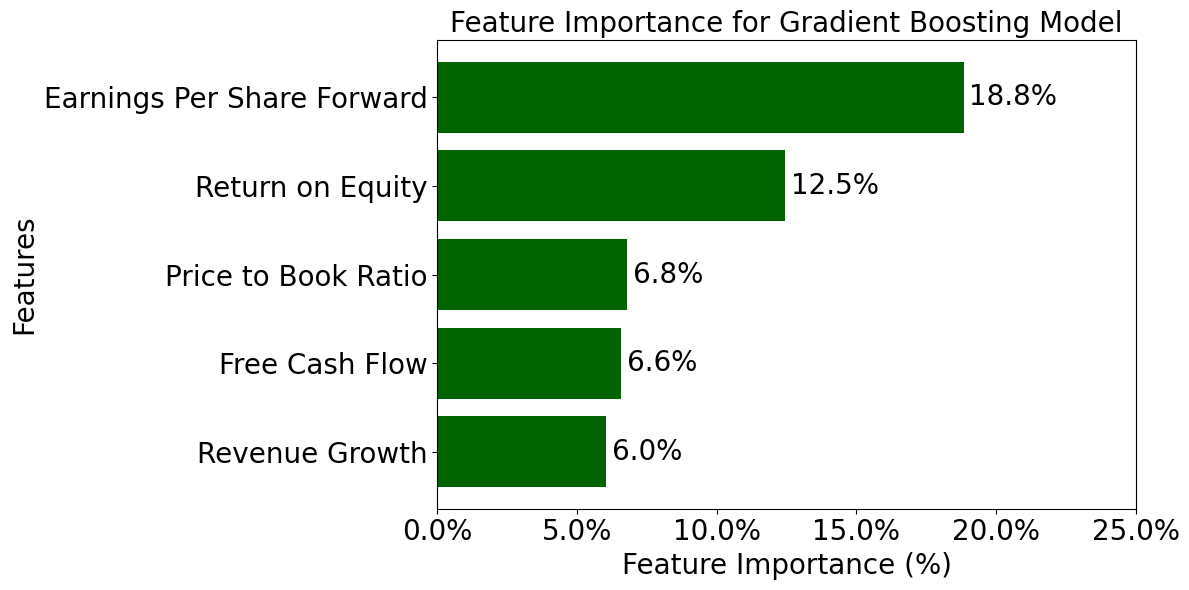

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Access feature importances from the trained Gradient Boosting model
feature_importances = pipeline_smoteen_gradient_boost.named_steps['classifier'].feature_importances_

# Create a DataFrame for better readability
importances_df = pd.DataFrame({
    'Feature': x_full.columns,
    'Importance': feature_importances
})

# Sort features by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Add percentage contribution for better interpretation
importances_df['Percentage'] = (importances_df['Importance'] / importances_df['Importance'].sum()) * 100

# Display top features
print("Top Feature Importances:")
print(importances_df)  # Adjust the number of top features to display

# Show only top 5 features on the plot
top_5_features = importances_df.head(5)

# Plot feature importances
plt.figure(figsize=(12, 6))
bars = plt.barh(top_5_features['Feature'], top_5_features['Percentage'], color='darkgreen')
plt.xlabel('Feature Importance (%)', fontsize=20)
plt.ylabel('Features', fontsize=20)
plt.title('Feature Importance for Gradient Boosting Model', fontsize=20)

# Adjust tick label font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add "%" symbol to x-axis values
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))

# Add percentage values to the right of the bars
for bar, percentage in zip(bars, top_5_features['Percentage']):
    plt.text(
        bar.get_width() + 0.2,  # Position to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered on the bar
        f'{percentage:.1f}%',  # Text to display
        va='center',  # Align text vertically
        ha='left',  # Align text horizontally
        fontsize=20
    )

plt.xlim(0, 25)  # Set the x-axis range from 0 to 30


plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## Feature Performance Evaluation
The feature contributing most to the features conbtributions is Earnings Per Share Forward at 18.8%%. Earnings Per Share Foward is an estimate of a company's future earnings per share for the next fiscal quarter or year, which is forecasted by financial analysts, investment firms, and research departments. Even though this is predicting what the stock's earnings report will be for the next quarter, it is not an example of data leakage because this is publicly available information and is only an estimate of the future earnings per share value. The next highest contributing feature is Return on Equity at 12.5%%. Return on Equity measures a company's profitability relative to its shareholders' equity. It's indicating how effectivley a companyis using the capital invested by its' shareholders to generate profits. 

The rest of the features contribute less than 8% each to the model's prediction, with the exception of PEG Ratio and Dividend Payment, which contribute 0%. 

## Stocks with Highest Probability of Beating Earnings
We're going to make a list of the top 25 stocks with the highest probability of beating their next estimated EPS, as predicted by the model. To do this, we'll use the y_full_proba, which is a variable we created in our model that retreives the probability that each stock will belong to class 1 (beating their estimated EPS). 


In [60]:
# Add probabilities and stock identifiers to a dataframe for the top 25 highest probability stocks
# Create a new DataFrame in order to keep the x_full DataFrame 
x_full_probability = x_full.copy()

# Add a column to the DataFrame called 'Probability' containing the y_full_proba values
# calculated by our model 
x_full_probability['Probability'] = y_full_proba

# Add the 'Symbol' column back into our Dataframe so we can see it
x_full_probability['Symbol'] = df_merged_stocks_data_scaled['Symbol']  # Replace 'stock_identifiers' with your column of stock tickers or names

# Create a DataFrame showing probabilities sorted (descending), stocks grouped by 'Symbol' as we 
# still have one row for each of the four quarterly estimated EPS  reports per stock, 
# and extract the top 25
top_25_stocks = x_full_probability.groupby('Symbol', as_index=False).agg('first').sort_values(by='Probability', ascending=False).head(25)

# Display the top 25 stocks
print("Top 25 Stocks with the Highest Probability of Beating Earnings:")
print(top_25_stocks[['Symbol', 'Probability']])


Top 25 Stocks with the Highest Probability of Beating Earnings:
     Symbol  Probability
1996    NVO     0.988774
1776   META     0.986799
1849    MRK     0.986706
10     ABBV     0.985300
1863   MSFT     0.985024
1662    LMT     0.984236
1458   INTU     0.984110
2656    SYK     0.983663
1721     MA     0.982952
731     CRM     0.982934
2290   QCOM     0.982636
2872      V     0.982531
1214   GILD     0.982119
89     AGYS     0.981985
2149    PEP     0.981877
1525    JNJ     0.981763
183    ANET     0.981698
2787   TSLA     0.981647
50     ADBE     0.981557
1932   NFLX     0.980907
1393    IBM     0.980716
2168    PGR     0.980403
1490   ISRG     0.980092
2110   PANW     0.979983
1187     GE     0.979315


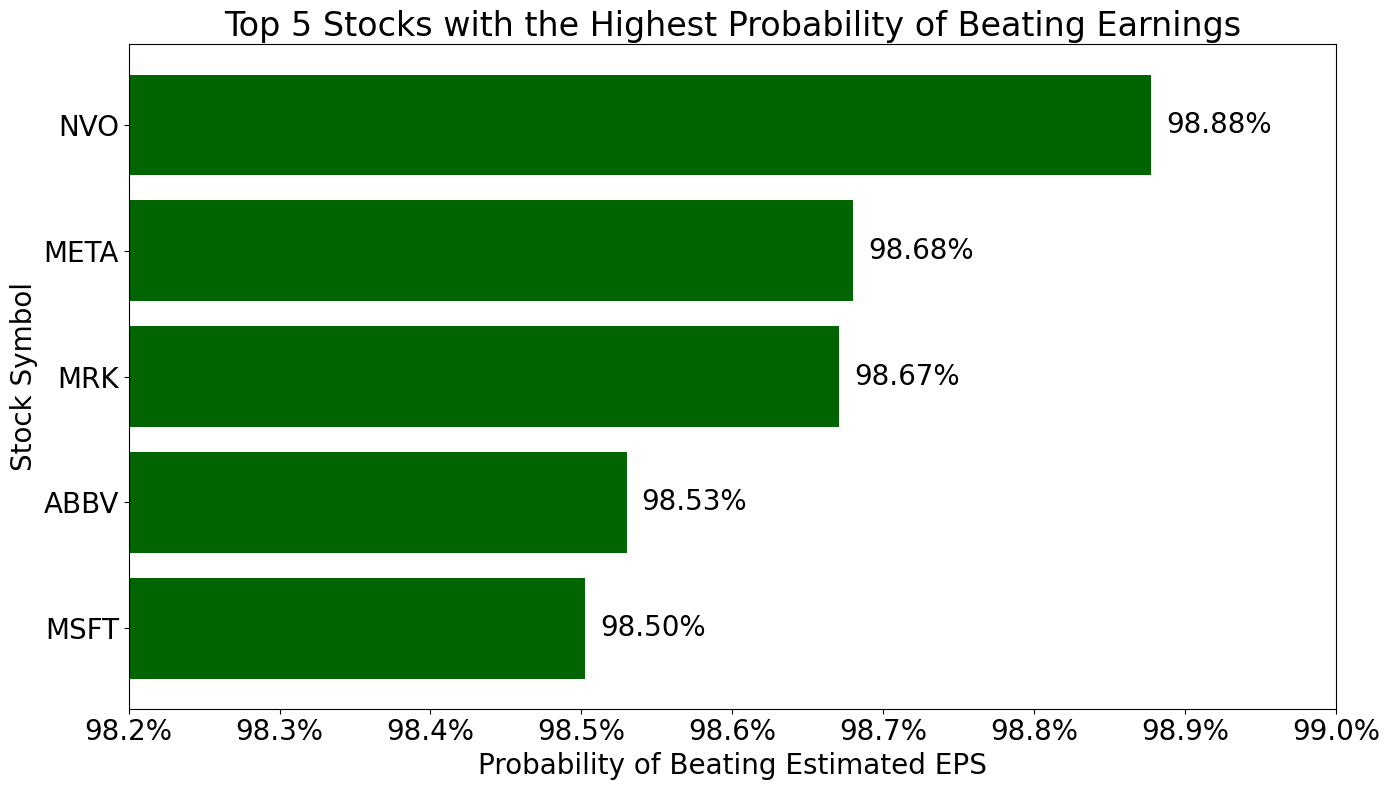

In [61]:
import matplotlib.pyplot as plt
import pandas as pd

# Your data preparation code remains the same
x_full_probability = x_full.copy()
x_full_probability['Probability'] = y_full_proba
x_full_probability['Symbol'] = df_merged_stocks_data_scaled['Symbol']

# Aggregate and sort data for the top 25 stocks
top_5_stocks = (
    x_full_probability.groupby('Symbol', as_index=False)
    .agg({'Probability': 'first'})  # Take the first probability per stock
    .sort_values(by='Probability', ascending=False)
    .head(5)
)

# Multiply probabilities by 100 for percentage values
top_5_stocks['Probability'] = top_5_stocks['Probability'] * 100

# Plotting the top 5 stocks
plt.figure(figsize=(14, 8))
bars = plt.barh(top_5_stocks['Symbol'], top_5_stocks['Probability'], color='darkgreen')
plt.xlabel('Probability of Beating Estimated EPS', fontsize=20)
plt.ylabel('Stock Symbol', fontsize=20)
plt.title('Top 5 Stocks with the Highest Probability of Beating Earnings', fontsize=24)

# Adjust tick label font sizes
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Add probability values to the right of the bars
for bar, probability in zip(bars, top_5_stocks['Probability']):
    plt.text(
        bar.get_width() + 0.01,  # Position to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically centered on the bar
        f'{probability:.2f}%',  # Text to display
        va='center',  # Align text vertically
        ha='left',  # Align text horizontally
        fontsize=20
    )

# Add "%" symbol to x-axis values
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.1f}%'))

plt.xlim(98.2, 99)  # Set the x-axis range from 95 to 96

plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()


## Conclusion
To wrap up this analysis, we'll end by giving an overall summary of the process we took to build our model, the limitations of data collection and model results, potential solutions to those limitations, future actions to improve our model.

### Summary
* Pull the top 5,000 stocks by market cap from the NASDAQ website (https://www.nasdaq.com/market-activity/stocks/screener) which gave us stock ticker, company name, and current market cap value
* Remove any stocks that aren't common shares, such as capital stock, registry shares, and global notes
* Import stock valuation parameters and earnings report history from Yahoo Finance for our list of stocks, remove unavailable parameter values, and impute specific values to maintain consistency in  the dataset
* Remove certain columns to prevent data leakage and scale the data in preparation for modeling
* Analyze metrics we will use to evaluate our model and decide which metric is most important for our business goal (Precision value)
* Run the data through two different types of models (Logistic Regression and Decision Tree) and choose which one has the best performance for our specific needs (Decision Tree)
* Implement data preprocessing techniques, tune hyperparameters, and compare the results of each modification to the baseline model to see if there was an increase in model performance. If an increase in performance is observed, keep the modification and move on to the next technique. Revise the model until performance improves to a sufficient level
* Run the final model on both the training dataset and testing dataset to confirm generalizing (model is not overfit to only work on the training data), run model on full dataset, and create a list of the top 25 stocks with the highest probability of beating their earnings report

### Limitations
* Data pulled from Yahoo Finance, while free, is limited in terms of real-time data and historical data. The market cap and valuation parameters are not updated in real time, but appear to be updated periodically, possible on a daily or weekly basis, though the exact timeframe is unknown. On top of this, there is a constraint on how much historical data can be retrieved. For example, only the most recent four quarterly earnings reports are available for stocks.
* Retrieving the original 24 stock valuation parameters for 5,000 stocks took almost an hour to generate. Future projects may lead to a dramatic increase in the number of parameters desired in order to discover new patterns and correlations in the data, increasing processing time exponentially.
* The main method for finding the ideal preprocessing techniques and hyperparameter tunings was trial-and-error. Hyperparameter optimization techniques, like GridSearchCV, reduce the number of models that need to be tested, streamlining the tuning process. Unfortunately, these optimization techniques required more computational resources than my computer could provide, preventing me from utilizing these strategies.
* Our target variable is earnings outcome, which is whether the stock beat their estimated earnings per share. A stock beating it's quarterly estimated earnings per share is a good indicator that the company is doing well fundamentally and has a much higher probability of increasing its' price, as opposed to a company that matched or missed its' estimated earnings per share. However, a company beating its' estimated earnings per share is not a guarantee that the stock will move up, especially in the short term. There are times where a company will greatly exceed its' estimated earnings per share, but the price will fall in the days following the announcement. This that there are other factors besdies beating its' estimated earnings per share that go into an increase in stock price. 

### Potential Solutions to these Limitations
* Financial data providers, such as Bloomberg Terminal and Alpha Vantage, provide APIs for accessing historical and real-time stock market data. These resources would provide us with accurate real-time data to ensure our model is up-to-date, along with extensive historical data spanning multiple years, rather than being limited to just a year or two. These services are expensive and cost anywhere from hundreds to thousands of dollars per month and have rate limits, which means that only a certain amount of data is able to be pulled every hour.
* There are a few options to reduce processing time for large dataset analysis and computationally intensive modeling. One option is to install one or multiple GPU (Graphics Processing Unit) units, which can significantly increase computational capability for tasks that involve large amounts of data and machine learning models. Another option is to invest in infrastructure, like powerful servers and GPUs, and rent out space in a data center. These data centers provide cooling, security, maintenance, and monitoring, reducing costs associated with real estate, power, cooling, and personnel. One more option is use Cloud Hosting, which is renting servers and GPUs from data centers or cloud providers, like Amazon Web Services (AWS), Google Cloud, or Microsoft Azure. This is the most cost effective in the short term, as we don't need to purchase or manage the hardware ourself. We pay for the computational power and resources used, and the provider is responsible for maintaining the infrastructure.
* Factors other than a stock beating its' estimated earnings per share may be a better indicator for a stock increasing in price, such as other types of valuation parameters or technical analysis indicators. We may also find that stocks that beat their estimated earnings per share may, on average, experience a percentage increase in price that is greater than the percentage decline when they miss estimates, leading to a long-term upward trend in average price. This would need to be calculated and proven using historical earnings reports and price data. 

### Future Actions for Improvement
* With the addition of Financial data providers, like Bloomberg Terminal, more stock valuation parameters and ratios will be available, which can be added to the model in order to see if any of them have a significant predictive power.
* Technical analysis (TA) is a method of evaluating future stock price movement using historical data, primarily price and volume. Unlike fundamental analysis, which focuses on a company's financial performance and intrinsic value (this project is based on fundamental analysis), TA is concerned with identifying patterns and trends in the data. TA often uses candlestick charts and uses mathhematical calculations based on price and volume, like Moving Averages (average price over a set period of time, i.e. 5 day MA, 50 day MA etc.), Relative Strength Index (measures the speed and chance of price movements to determine overbought or oversold conditions), Bollinger Bands (indicates price volatility by plotting two standard deviationos away from a moving average), and many more. Since these indicators and patterns are used by stock/commodity traders to determine future price movements, we can try implementing these tools to our model to see if they enhance predictive power.
* In this model, we focused on logistic regression and decision trees. However, other machine learning algorithms and statistical approaches, such as Support Vector Machines (SVM), Neural Networks, and Random Forest. Most of these require greater computational power than the approach taken in this project, but may lead to more robust model. 